In [40]:
import re
from collections import Counter
import statistics as stats
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from difflib import SequenceMatcher
from typing import List, Dict, Optional, Union
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

## python methods for each tutorial

In [4]:
def dashshound_clean_and_structure(text: str) -> List[Dict[str, Union[int, str, None]]]:
    """
    Cleans and structures crochet pattern text into a list of structured instructions.

    This function processes a multi-line string representing a crochet pattern, extracts
    round numbers, instructions, and stitch counts, and returns a structured list of
    dictionaries containing the processed data.

    Args:
        text (str): The raw crochet pattern text to be processed.

    Returns:
        List[Dict[str, Union[int, str, None]]]: A list of dictionaries, where each dictionary
        represents a round and contains the following keys:
            - "round" (int): The round number.
            - "round_continuous" (int): The continuous round count (1-based index).
            - "instructions" (str): The instructions for the round.
            - "count" (Optional[int]): The stitch count for the round, if available.
    """
    lines = text.splitlines()
    instructions = []

    # Regex patterns for parsing
    round_pattern = re.compile(r"^r(\d+)(?:-(\d+))?:")  # Matches r1 or r1-5
    count_pattern = re.compile(r"\((\d+)\)")  # Matches stitch count in parentheses
    count_inline_pattern = re.compile(r"(\d+)\s*sc")  # Matches inline counts like '12sc'
    instruction_pattern = re.compile(r":\s*(.+)")  # Matches instructions after colon

    for line in lines:
        line = line.strip()
        if not line.startswith("r"):  # Skip irrelevant lines
            continue

        # Extract round numbers
        round_match = round_pattern.search(line)
        if not round_match:
            continue

        round_start = int(round_match.group(1))
        round_end = int(round_match.group(2)) if round_match.group(2) else round_start

        # Extract instructions
        instruction_match = instruction_pattern.search(line)
        if not instruction_match:
            continue
        raw_instructions = instruction_match.group(1).strip()

        # Extract final count (if present)
        count_match = count_pattern.search(raw_instructions) or count_inline_pattern.search(raw_instructions)
        count = int(count_match.group(1)) if count_match else None

        # Add to the structured output
        for round_num in range(round_start, round_end + 1):
            instructions.append({
                "round": round_num,
                "round_continuous": len(instructions) + 1,
                "instructions": raw_instructions,
                "count": count
            })

    return instructions

In [8]:
def rabbit_clean_and_structure(text: str) -> List[Dict[str, Union[int, str, None]]]:
    """
    Cleans and structures crochet pattern text into a list of structured instructions.

    This function processes a multi-line string representing a crochet pattern, extracts
    round numbers, instructions, and stitch counts, and returns a structured list of
    dictionaries containing the processed data.

    Args:
        text (str): The raw crochet pattern text to be processed.

    Returns:
        List[Dict[str, Union[int, str, None]]]: A list of dictionaries, where each dictionary
        represents a round and contains the following keys:
            - "round" (int): The round number.
            - "round_continuous" (int): The continuous round count (1-based index).
            - "instructions" (str): The instructions for the round.
            - "count" (Optional[int]): The stitch count for the round, if available.
    """
    lines = text.splitlines()
    instructions = []

    # Regex patterns for parsing
    round_pattern = re.compile(r"^r(\d+)(?:-(\d+))?:")  # Matches r1 or r1-5
    count_pattern = re.compile(r"\((\d+)\)")  # Matches stitch count in parentheses
    count_inline_pattern = re.compile(r"(\d+)\s*sc")  # Matches inline counts like '12sc'
    instruction_pattern = re.compile(r":\s*(.+)")  # Matches instructions after colon

    for line in lines:
        line = line.strip()
        if not line.startswith("r"):  # Skip irrelevant lines
            continue

        # Extract round numbers
        round_match = round_pattern.search(line)
        if not round_match:
            continue

        round_start = int(round_match.group(1))
        round_end = int(round_match.group(2)) if round_match.group(2) else round_start

        # Extract instructions
        instruction_match = instruction_pattern.search(line)
        if not instruction_match:
            continue
        raw_instructions = instruction_match.group(1).strip()

        # Extract final count (if present)
        count_match = count_pattern.search(raw_instructions) or count_inline_pattern.search(raw_instructions)
        count = int(count_match.group(1)) if count_match else None

        # Add to the structured output
        for round_num in range(round_start, round_end + 1):
            instructions.append({
                "round": round_num,
                "round_continuous": len(instructions) + 1,
                "instructions": raw_instructions,
                "count": count
            })

    return instructions

In [10]:
def rabbit_calculate_aggregate_stats_with_exceptions(structured_data: List[Dict[str, str]]) -> Dict[str, int]:
    """
    Calculate aggregate statistics (total stitches, increases, decreases, and count) 
    from structured crochet pattern data while handling exceptions.

    Args:
        structured_data (List[Dict[str, str]]): A list of dictionaries where each dictionary
            contains an 'instructions' key with crochet pattern details and a 'count' key 
            indicating the total count for that entry.

    Returns:
        Dict[str, int]: A dictionary containing the total stitches, increases, decreases, and count.
    """
    # Regex patterns for identifying stitches, increases, and decreases
    sc_pattern = re.compile(r"\b(\d+)\s*sc\b")
    inc_pattern = re.compile(r"\b(\d+)\s*inc\b")
    dec_pattern = re.compile(r"\b(\d+)\s*dec\b")

    # Initialize aggregate counters
    total_stitches = 0
    total_increases = 0
    total_decreases = 0
    total_count = 0

    for entry in structured_data:
        instructions = entry.get("instructions", "")
        count = entry.get("count", 0)

        # Exception handling: If the 'count' value should be used directly
        if "sc" in instructions and "(" in instructions and ")" in instructions:
            total_count += count
            continue

        # Extract numerical values using regex patterns
        sc_matches = sc_pattern.findall(instructions)
        inc_matches = inc_pattern.findall(instructions)
        dec_matches = dec_pattern.findall(instructions)

        # Sum up matched values
        total_stitches += sum(map(int, sc_matches))
        total_increases += sum(map(int, inc_matches))
        total_decreases += sum(map(int, dec_matches))
        total_count += count if count else 0

    return {
        "total_stitches": total_stitches,
        "total_increases": total_increases,
        "total_decreases": total_decreases,
        "total_count": total_count,
    }

In [12]:
def rabbit_pl_clean_and_structure_data(text: str) -> List[Dict[str, int]]:
    """
    Clean and structure raw crochet pattern text by normalizing, extracting relevant data,
    and structuring it into a list of dictionaries.

    Args:
        text (str): Raw crochet pattern text.

    Returns:
        List[Dict[str, int]]: A structured list containing round information, instructions, and count.
    """
    # Normalize the text
    lines = text.lower().split("\n")
    cleaned_lines = []

    for line in lines:
        # Keep only lines starting with "r" followed by a number or space
        if re.match(r"^r[0-9i\s:-]+", line):
            # Normalize common issues in OCR text
            line = re.sub(r"ri\s*", "r", line)  # Fix 'ri' to 'r'
            line = re.sub(r"\s+", " ", line)  # Remove extra spaces
            line = re.sub(r"\s*:\s*", ":", line)  # Standardize colon spacing
            cleaned_lines.append(line.strip())

    structured_data = []
    seen_entries = set()  # To track duplicates
    round_continuous = 1  # To track continuous round numbers

    for line in cleaned_lines:
        # Extract round info, instructions, and count using regex
        match = re.match(r"r(\d+)(?:-(\d+))?:\s*(.*)\((\d+)\)", line)
        if match:
            start_round = int(match.group(1))
            end_round = int(match.group(2)) if match.group(2) else start_round
            instructions = match.group(3).strip()
            count = int(match.group(4))

            # Create entries for each round in a range
            for round_num in range(start_round, end_round + 1):
                entry = {
                    "round": round_num,
                    "round_continuous": round_continuous,
                    "instructions": instructions,
                    "count": count
                }
                entry_tuple = tuple(entry.items())  # Convert dict to tuple for deduplication

                if entry_tuple not in seen_entries:  # Check for duplicates
                    structured_data.append(entry)
                    seen_entries.add(entry_tuple)  # Add to seen set
                    round_continuous += 1  # Increment continuous round counter

    return structured_data

In [15]:
def rabbit_pl_original_clean_and_structure(text: str) -> List[Dict[str, int]]:
    """
    Process raw crochet pattern text, extracting round information, instructions, and count,
    then structure it into a cleaned format.

    Args:
        text (str): Raw crochet pattern text.

    Returns:
        List[Dict[str, int]]: A structured list of dictionaries containing round details.
    """
    # Split input text into lines
    lines = text.splitlines()

    # Regex to match round lines
    round_regex = re.compile(r"R(\d+)(?:-(\d+))?:\s*(.+?)\s*\((\d+)\)")

    structured_data = []
    continuous_round = 1

    for line in lines:
        match = round_regex.search(line)
        if match:
            start_round = int(match.group(1))
            end_round = int(match.group(2)) if match.group(2) else start_round
            instructions = match.group(3).strip()
            count = int(match.group(4))

            # Generate entries for all rounds in the range
            for round_num in range(start_round, end_round + 1):
                structured_data.append({
                    "round": round_num,
                    "round_continuous": continuous_round,
                    "instructions": instructions,
                    "count": count
                })
                continuous_round += 1

    # Remove duplicates (if any)
    df = pd.DataFrame(structured_data).drop_duplicates()

    return df.to_dict(orient="records")

In [18]:
def partial_compare(list1, list2, keys):
    # Extract relevant keys from dictionaries
    set1 = {tuple((k, d[k]) for k in keys if k in d) for d in list1}
    set2 = {tuple((k, d[k]) for k in keys if k in d) for d in list2}

    # Find similarities and differences
    similarities = set1.intersection(set2)
    differences1 = set1 - set2
    differences2 = set2 - set1

    return similarities, differences1, differences2

In [20]:
def string_similarity(str1, str2):
    return SequenceMatcher(None, str1, str2).ratio()

# Compare similarity for each dictionary
def compare_with_similarity(list1, list2):
    results = []
    for d1 in list1:
        for d2 in list2:
            if d1['round_continuous'] == d2['round_continuous']:
                sim = string_similarity(d1['instructions'], d2['instructions'])
                results.append({
                    'round_continuous': d1['round_continuous'],
                    'similarity': sim,
                    'list1_instructions': d1['instructions'],
                    'list2_instructions': d2['instructions']
                })
    return results

In [24]:
import re

def fox_clean_and_parse(data):
    """
    Cleans and parses the input data, correcting OCR issues, extracting round instructions,
    and returning the parsed instruction details.

    Args:
        data (str): Raw input string containing round instructions.

    Returns:
        list: A list of dictionaries containing parsed round instructions.
    """

    # Step 1: Preprocess the text
    lines = data.splitlines()
    cleaned_lines = []

    for line in lines:
        # Normalize common OCR issues
        line = line.strip().lower()
        line = re.sub(r"ri", "r1", line)  # Correct 'ri' to 'r1'
        line = re.sub(r"\s+", " ", line)  # Remove extra spaces
        line = re.sub(r"\*", "", line)  # Remove stray asterisks

        if line.startswith("r") and re.match(r"r\d", line):  # Only keep valid rounds
            cleaned_lines.append(line)

    # Step 2: Parse each line
    parsed_instructions = []
    round_continuous = 1

    for line in cleaned_lines:
        # Match single or range rounds, instructions, and stitch count
        match = re.match(r"r(\d+)(?:-(\d+))?:\s*(.+?)\s*(?:\((\d+)\))?$", line)
        if match:
            start_round = int(match.group(1))
            end_round = int(match.group(2)) if match.group(2) else start_round
            instructions = match.group(3)
            stitch_count = match.group(4)

            # If stitch_count is missing, try to extract it from the instructions
            if not stitch_count:
                # Match patterns like "15 sc", "36sc", etc.
                sc_match = re.search(r"(\d+)\s*sc", instructions)
                if sc_match:
                    stitch_count = int(sc_match.group(1))

            stitch_count = int(stitch_count) if stitch_count else None

            # Generate entries for each round in the range
            for rnd in range(start_round, end_round + 1):
                parsed_instructions.append({
                    "round": rnd,
                    "round_continuous": round_continuous,
                    "instructions": instructions,
                    "count": stitch_count
                })
                round_continuous += 1

    # Step 3: Deduplicate entries
    seen = set()
    unique_instructions = []

    for instruction in parsed_instructions:
        # Convert instruction to a tuple and check for uniqueness
        instruction_tuple = tuple(instruction.items())
        if instruction_tuple not in seen:
            unique_instructions.append(instruction)
            seen.add(instruction_tuple)

    return unique_instructions

In [27]:
def reindeer_parse_crochet_instructions(sample_text: str) -> List[Dict[str, Optional[int]]]:
    """
    Parses crochet instructions from a given text. The function supports formats like:

    - r1: 6 in mr [6]
    - r7-8: sc in each [36]

    The function splits the input text into lines, then parses each line for round information, instructions,
    and stitch counts. It supports ranges of rounds (e.g., r7-8), extracts the relevant instructions, and provides
    parsed results in a structured format.

    Args:
        sample_text (str): A string containing crochet round instructions.

    Returns:
        List[Dict[str, Optional[int]]]: A list of dictionaries where each dictionary contains:
            - 'round': The round number (int).
            - 'round_continuous': A continuous count of parsed rounds (int).
            - 'instructions': The crochet instructions for the round (str).
            - 'count': The stitch count for the round, if available (Optional[int]).

       """
    
    # Split the text into lines
    lines = sample_text.splitlines()

    # Regex pattern to match crochet instructions
    round_pattern = re.compile(
        r"r(\d+)(?:[-–](\d+))?:\s*(.+?)\s*\[?(\d+)?\]?$"
    )
    
    parsed_instructions: List[Dict[str, Optional[int]]] = []
    round_continuous = 1

    for line in lines:
        match = round_pattern.search(line)
        if match:
            start_round = int(match.group(1))
            end_round = int(match.group(2)) if match.group(2) else start_round
            instructions = match.group(3).strip()
            count = int(match.group(4)) if match.group(4) else None

            # Loop through the range of rounds if a range is specified (e.g., r7-8)
            for current_round in range(start_round, end_round + 1):
                parsed_instructions.append({
                    "round": current_round,
                    "round_continuous": round_continuous,
                    "instructions": instructions,
                    "count": count
                })
                round_continuous += 1

    return parsed_instructions

In [30]:
import re
from typing import List, Dict


def penguin_process_crochet_instructions(text: str) -> List[Dict[str, int]]:
    """
    Processes crochet instructions from a given text, extracting round information, 
    instructions, and stitch counts. The function supports round ranges (e.g., r1-3) 
    and returns structured data.

    Args:
        text (str): A string containing crochet round instructions.

    Returns:
        List[Dict[str, int]]: A list of dictionaries where each dictionary contains:
            - 'round': The round number (int).
            - 'round_continuous': A continuous count of parsed rounds (int).
            - 'instructions': The crochet instructions for the round (str).
            - 'count': The stitch count for the round (int).

  """

    # Split lines, focusing on 'r' instructions
    lines = [line.strip() for line in text.splitlines() if line.strip().startswith('r')]
    
    structured_data: List[Dict[str, int]] = []
    round_continuous = 1

    for line in lines:
        # Match round, range, instructions, and count
        match = re.match(r"r(\d+)(?:-(\d+))?:\s*(.*?)[.;]?\s*\((\d+)\)", line)
        if match:
            start_round, end_round, instructions, count = match.groups()
            start_round = int(start_round)
            end_round = int(end_round) if end_round else start_round
            count = int(count)

            # Expand ranges
            for round_num in range(start_round, end_round + 1):
                structured_data.append({
                    "round": round_num,
                    "round_continuous": round_continuous,
                    "instructions": instructions.strip(),
                    "count": count
                })
                round_continuous += 1

    # Deduplicate consecutive identical entries
    deduplicated_data: List[Dict[str, int]] = []
    for i, entry in enumerate(structured_data):
        if i == 0 or entry != structured_data[i - 1]:
            deduplicated_data.append(entry)
    
    return deduplicated_data


In [33]:
import re
from typing import List, Dict, Optional


def panda_extract_instructions(text: str) -> List[Dict[str, Optional[int]]]:
    """
    Extracts crochet instructions from the given text. The function handles both 
    individual rounds and ranges (e.g., r8-13), processes the instructions, and 
    returns a structured list with round numbers, instructions, and optional stitch counts.

    Args:
        text (str): A string containing crochet round instructions.

    Returns:
        List[Dict[str, Optional[int]]]: A list of dictionaries where each dictionary contains:
            - 'round': The round number (int).
            - 'round_continuous': A continuous count of parsed rounds (int).
            - 'instructions': The crochet instructions for the round (str).
            - 'count': The stitch count for the round (Optional[int]).
    """

    lines = text.splitlines()
    instructions: List[Dict[str, Optional[int]]] = []
    round_counter = 0
    seen_rounds = set()

    for line in lines:
        # Normalize the line
        line = line.lower().strip()

        # Handle ranges like r8-13
        range_match = re.match(r"r(\d+)-r(\d+)\s*\(?\d*r\)?\s*[:;]?\s*(.*)", line)
        if range_match:
            start, end, instruction_text = range_match.groups()
            start, end = int(start), int(end)
            
            # Extract stitch count from brackets
            count_match = re.search(r"\[(\d+)\]", instruction_text)
            stitch_count = int(count_match.group(1)) if count_match else None

            for round_number in range(start, end + 1):
                round_counter += 1
                instructions.append({
                    "round": round_number,
                    "round_continuous": round_counter,
                    "instructions": instruction_text.strip(),
                    "count": stitch_count
                })
            continue

        # Match single rounds like r1, r2, etc.
        match = re.match(r"r(\d+)\s*[:;]?\s*(.*)", line)
        if match:
            round_text, instruction_text = match.groups()

            # Normalize OCR errors and get the round number
            round_number = round_text.strip()
            if round_number.isdigit():
                round_number = int(round_number)
            else:
                continue

            round_counter += 1

            # Extract stitch count from brackets
            count_match = re.search(r"\[(\d+)\]", instruction_text)
            stitch_count = int(count_match.group(1)) if count_match else None

            # Append structured result
            instructions.append({
                "round": round_number,
                "round_continuous": round_counter,
                "instructions": instruction_text.strip(),
                "count": stitch_count
            })

    # Deduplicate consecutive identical instructions
    unique_instructions: List[Dict[str, Optional[int]]] = []
    for i, entry in enumerate(instructions):
        if i == 0 or entry != instructions[i - 1]:
            unique_instructions.append(entry)

    return unique_instructions


In [36]:
def mr_bear_clean_and_structure_data(raw_text: str) -> List[Dict[str, Optional[int]]]:
    """
    Cleans and structures crochet instructions from raw text, processing round 
    ranges and individual rounds, and extracting instructions and stitch counts.

    Args:
        raw_text (str): The raw input text containing crochet round instructions.

    Returns:
        List[Dict[str, Optional[int]]]: A list of dictionaries where each dictionary contains:
            - 'round': The round number (int).
            - 'round_continuous': A continuous count of parsed rounds (int).
            - 'instructions': The crochet instructions for the round (str).
            - 'count': The stitch count for the round (Optional[int]).
    """

    # Split lines and normalize whitespace
    lines = raw_text.splitlines()
    normalized_lines = [re.sub(r'\s+', ' ', line.strip().lower()) for line in lines]

    # Regex patterns for extracting rounds and instructions
    round_pattern = re.compile(r"r(\d+)(?:-(\d+))?[:\s]")
    instruction_pattern = re.compile(r"r\d+.*?:\s*(.*?)(?:\[(\d+)\])?$")

    structured_data: List[Dict[str, Optional[int]]] = []
    round_counter = count(1)  # Continuous round counter
    previous_instruction = None

    for line in normalized_lines:
        match = round_pattern.search(line)
        if match:
            start_round = int(match.group(1))
            end_round = int(match.group(2)) if match.group(2) else start_round

            instruction_match = instruction_pattern.search(line)
            if instruction_match:
                instructions = instruction_match.group(1).strip()
                count_val = instruction_match.group(2)
                count_val = int(count_val) if count_val and count_val.isdigit() else None

                # Expand ranges and add structured data
                for round_num in range(start_round, end_round + 1):
                    current_round = next(round_counter)
                    if (round_num, instructions, count_val) != previous_instruction:
                        structured_data.append({
                            "round": round_num,
                            "round_continuous": current_round,
                            "instructions": instructions,
                            "count": count_val
                        })
                        previous_instruction = (round_num, instructions, count_val)
            else:
                # Handle unparsed lines (optional logging or debugging)
                pass

    return structured_data

In [38]:
def bee_process_crochet_instructions(text: str) -> List[Dict[str, int]]:
    """
    Processes crochet instructions from a given text, extracting round numbers, 
    instructions, and stitch counts. The function handles both single rounds and 
    ranges, and ensures that consecutive identical entries are deduplicated.

    Args:
        text (str): The raw input text containing crochet round instructions.

    Returns:
        List[Dict[str, int]]: A list of dictionaries where each dictionary contains:
            - 'round': The round number (int).
            - 'round_continuous': A continuous count of parsed rounds (int).
            - 'instructions': The crochet instructions for the round (str).
            - 'count': The stitch count for the round (int).
    """

    # Split the input text into lines and focus on those starting with 'r'
    lines = [line.strip() for line in text.splitlines() if line.strip().startswith('r')]
    
    structured_data: List[Dict[str, int]] = []
    round_continuous = 1  # To track continuous round numbers

    for line in lines:
        # Match round range, instructions, and stitch count
        match = re.match(r"r(\d+)(?:-(\d+))?:\s*(.*?)\s*\[(\d+)\]", line)
        if match:
            start_round, end_round, instructions, count = match.groups()
            start_round = int(start_round)
            end_round = int(end_round) if end_round else start_round
            count = int(count)

            # Expand ranges and add to structured data
            for round_num in range(start_round, end_round + 1):
                structured_data.append({
                    "round": round_num,
                    "round_continuous": round_continuous,
                    "instructions": instructions.strip(),
                    "count": count
                })
                round_continuous += 1

    # Deduplicate consecutive identical entries
    deduplicated_data: List[Dict[str, int]] = []
    for i, entry in enumerate(structured_data):
        if i == 0 or entry != structured_data[i - 1]:
            deduplicated_data.append(entry)

    return deduplicated_data

## dashshound

In [6]:
sample_text = """
r1: 6 sc in a mr (6)
r2: 6 inc (12)
r3: (sc, inc)*6 (18)
r5 (sc irc)*6 (18)
r4: 18 sc
r5: (5 sc, inc)*3 (21)
r6-9: 21 sc (21)
r10: inc, 3 sc, 4 inc, 3 sc, inc, 9 sc (27)
r11: inc, 4 sc, (sc, inc)*4, 4 sc, inc, 9 sc (33)
r12: inc, (5 sc, inc)*4, 8 sc (38)
r13: (6 inc)*4, 10 sc (42)
r14-18: 42 sc (42)
r19: (5 sc, dec)*6 (36)
r20: (4 sc, dec)*6 (30)
r21: (3 sc, dec)*6 (24)
r22 (2 sc, dec)*6 (18)
r23: (sc dec)*6 (12)
r24: 6 dec (6)
r1: 6 sc in a mr (6)
r2: 6 inc (12)
r3: (sc, inc)*6 (18)
r4: (2 sc, inc)*6 (24)
r5: (3 sc, inc)*6 (30)
r6: (4 sc, inc)*6 (36)
r7-10: 36 sc (36)
r11: (10sc dec)*3 (33)
r12: 33 sc (33)
r13: (9sc, dec)*3 (30)
r14: 30 sc (30)
r15: (8sc, dec)*3 (27)
r16: (7sc, dec)*3 (24)
r17: (2sc, dec)*6 (18)
r18: 18 sc (18)
r19: (4sc, dec)*3 (15)
r20-22: 15 sc (15)
r1: join with sc to 1st ch to form a ring (mark this stitch) , then 15 sc around (16)
r2-3: 16 sc (2 rounds of 16)
r4: (3 sc, inc)*4 (20)
r5: ch19 (19)
r6: hdc inc, hdc, hdcinc, 18 hdc, 22 sc, 18 hdc, hdc inc, hdc, hdc inc (68)
r7: hdc inc, 2 hdc, hdc inc, 19 hdc, 22 sc, 19 hdc, hdc inc, 2 hdc, hdc inc (72)
r8-10: 72 sc (3 rounds of 72)
r11: 4 sc, dec, 20 sc, dec, (4 sc, dec)*3, 20 sc, dec, 4 sc (66)
r12: 56sc (56)
r13: (sc, dec)*2, 19sc, dec, (sc, dec)*4, 19 sc, dec, (sc deci (56)
r14: 3 dec, 20 sc, 4 dec, 20 sc, dec (48)
r1: sc in a mr (7)
r2: 7 inc (14)
r3: 14 sc in blo back loops (14)
r4-5: 14 sc (2 rounds of 14)
r1: 4 sc a mr (4)
r2-11: 4 sc (4)
"""

In [7]:
structured_data = dashshound_clean_and_structure(sample_text)

In [452]:
df_jamnik = pd.DataFrame(structured_data)

# Ensure `round` is numeric and continuous, and fill missing `count` with NaN
df_jamnik['round_continuous'] = pd.to_numeric(df_jamnik['round_continuous'], errors='coerce')
df_jamnik['round'] = pd.to_numeric(df_jamnik['round'], errors='coerce')
df_jamnik['count'] = pd.to_numeric(df_jamnik['count'], errors='coerce')

# Sort data by round and remove duplicates (keeping the first occurrence)
df_jamnik = df_jamnik.sort_values('round_continuous')

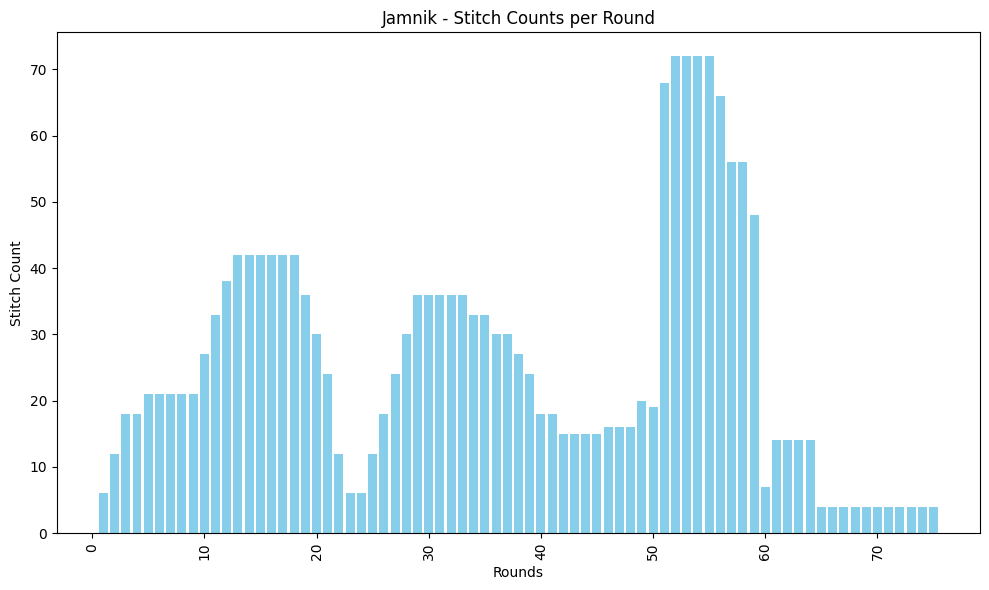

In [454]:
plt.figure(figsize=(10, 6))
plt.bar(df_jamnik['round_continuous'], df_jamnik['count'], color='skyblue')
plt.xticks(rotation=90)
plt.title("Jamnik - Stitch Counts per Round")
plt.xlabel("Rounds")
plt.ylabel("Stitch Count")
plt.tight_layout()
plt.show()

## RABBIT JULA

In [9]:
sample_text = """
rode fily amigurumi desig n
rode fily a migurumi design
( 1 hobbll
chunky plush yarn : chain , white ( tail ) , pink ( nose ) , other ( headband ) medium weight yarn : black ( nose ) , white ( eyes ) coto n u 6 l jor polyettee hobbli
chunky plush yarn : chain , white ( tail ) , pink ( nose ) , other ( headband ) medium weight yarn : black ( nose ) , white ( eyes ) come n u 61 pjol polyette hobbli m
chunky plush yarn : chain , white ( tail ) , pink ( nose ) , other ( headband ) medium weight yarn : black ( nose ) , white ( eyes ) coto 1 n u g 1 jol polyette hobbli
chunky plush yarn : chain , white ( tail ) , pink ( nose ) , ther ( headband ) medium weight yarn : black ( nose ) , white ( eyes ) como n u tjor polyette hobbli
chunky plush yarn : chain , white ( tail ) , pink ( nose ) , other ( headband ) medium weight yarn : black ( nose ) , white ( eyes ) como 1 e n u 61 pjoi polyette hobbli
chunky plush yarn : chain , white ( tail ) , pink ( nose ) , other ( headband ) medium weight yarn : black ( nose ) , white ( eyes ) como n u tjor polyette hobbli
chunky plush yarn : chain , white ( tail ) , pink ( nose ) , other ( headband ) medium weight yarn : black ( nose ) , white ( eyes ) come 6 n u jor polyette hobbli
12mm safety eyes us g 4.25mm crochet hook yarn needle scissors poly fill stitch markers
12mm safety eyes us g 4.25mm crochet hoo yarn needle scissors poly fill stitch markers
magic ring single crochet slip stitch chain stitch increase invisible decrease
r1: 6 sc in a mr
r2: 6 inc (12)
r3-5: 12sc
1 st leg only : close and cut yarn
1 st only : close and cut yarn leg
crochet tle tle same af tle pog drt close or e t rn
crochet tke tl fame aj tle fpol dnt or cut arn close
crochet tke tle fame af tke pog dt close or cut arn
jjoin t 0 istleg wlth a sc ( tail is r1 of belly )
join to 1 st with a sc ( tail is r1 of belly ) leg
join to 1 st with sc ( tail is r1 of belly ) leg
join to 1 st with a sc ( tail is r1 of belly ) leg
r1: 24 sc (12sc in 1st leg, 12sc in 2nd leg)
r2: (3sc, inc)*6 (30)
r3-7: 30 sc
r8: (3sc, dec)*6 (24}
r9: 24sc
r10: (2sc, dec)*.6 (18)
r11: (sc, dec)*6 (12)
r12: 12 sc subscribed
r13: 12 inc (24)
r14: (3 sc, inc) 6 (30)
r15-19: 30 sc
eyes : between r17 and r18 , 4 sts apart
eyes : between r17 and r18 , sts apart
eyes : between r17 and r18 , 4 sts apart
eyes : between r17 and r184 sts apart
eyes : between r17 and r18 , 4 sts apart
r20: (3 sc, dec)*(24)
r21: (2 sc, dec) 6 6 81
r22: (sc, dec)*6 (12)
r23: 6 dec (6)
r1: 6 sc in a mr
r2-6: 6 sc
r1: 6 sc in a mr
r2: (2 sc, inc)*2 (8)
r3: (2 sc, dec) (6)
close with a sl st
with 4 sl 5 t
tlanes for 1 wotsird yarn ,
tlanes for 1 watlird l yarn
tlanes for 1 watsirz yarn
tlanks for 1 watsird l yarn
tlanes for 1 watsird l yarn
tlanes for 1 watslird l yarn
rode fily amigurumi desig n
rode fily a migurumi design
yarn assembly headband
yarn assemb headband
yarn assembly headband
yarn assembly headbandr
r1: 6 sc in a mr
r2: 6 inc (12) 2 s
r3: (sc, inc)*6 (18)
r4: (2 sc, inc)*6 (24)
r5-10: 24 sc
r11: (6 sc, dec)*3 (21)
r12: 21 sc
r13: (5 sc, dec)*3 (18)
r14: 18 sc 
r15: (4 sc, dec)*3 (15)
r16-19: 15 sc (15)
r20: (3 sc, dec)*3 (12)
r21-22: 12 sc
fold and sc closed along top flat ,
fold flat , and sc closed along top
fold flat , and sc closed along top ,
fold flat , and sc closed along top
assem a
assem y 4
9
chdccdidcn
2
stuff before reaching end if desired
t
m
roseandlilyamigurumi com
roseandlilyamigurumi : com
roseandlilyamigurumicom
roseandlilyamigurumi com
"""

structured_data = rabbit_clean_and_structure(sample_text)

In [457]:
round_stats = []

for round_ in structured_data:
    instructions = round_['instructions']
    
    # Handle exceptions where the instructions include nested counts in parentheses
    if "sc" in instructions and "(" in instructions and ")" in instructions:
        round_stats.append({
            'round': round_['round_continuous'],
            'total_stitches': 0,  # Assume stitches are directly included in the count
            'total_increases': 0,  # No explicit increases or decreases to count
            'total_decreases': 0,
            'total_count': round_['count']  # Use the provided count
        })
        continue
    
    # Parse the normal instructions
    total_stitches = sum(map(int, re.findall(r'(\d+)\s*sc', round_['instructions'])))
    total_increases = sum(map(int, re.findall(r'(\d+)\s*inc', round_['instructions'])))
    total_decreases = sum(map(int, re.findall(r'(\d+)\s*dec', round_['instructions'])))
    
    round_stats.append({
        'round': round_['round_continuous'],
        'total_stitches': total_stitches,
        'total_increases': total_increases,
        'total_decreases': total_decreases,
        'total_count': round_['count']
    })

In [459]:
filtered_data = [value.get('total_count') for value in round_stats if value.get('total_count') is not None]
max_stitches = max(round_stats, key=lambda x: x.get('total_stitches', 0) or 0)

# Find the round with the minimum total_stitches
min_stitches = min(round_stats, key=lambda x: x.get('total_stitches', 0) or 0)


# Find max and min
max_value = max(filtered_data)
min_value = min(filtered_data)

In [460]:
total_rounds = len(round_stats)
max_stitches = max(round_stats, key=lambda x: x.get('total_stitches', 0) or 0)
min_stitches = min(round_stats, key=lambda x: x.get('total_stitches', 0) or 0)
increase_stats = Counter([stat['total_increases'] for stat in round_stats])
decrease_stats = Counter([stat['total_decreases'] for stat in round_stats])
filtered_count = [value.get('total_count') for value in round_stats if value.get('total_count') is not None]


# Output results
print(f"Total rounds: {total_rounds}")
print(f"Round with maximum stitches: {max_stitches}")
print(f"Round with minimum stitches: {min_stitches}")
print(f"Increase frequency distribution: {increase_stats}")
print(f"Decrease frequency distribution: {decrease_stats}")

Total rounds: 59
Round with maximum stitches: {'round': 8, 'total_stitches': 30, 'total_increases': 0, 'total_decreases': 0, 'total_count': 30}
Round with minimum stitches: {'round': 2, 'total_stitches': 0, 'total_increases': 6, 'total_decreases': 0, 'total_count': 12}
Increase frequency distribution: Counter({0: 56, 6: 2, 12: 1})
Decrease frequency distribution: Counter({0: 58, 6: 1})


In [11]:
aggregate_stats = rabbit_calculate_aggregate_stats_with_exceptions(structured_data)

# Output
print(aggregate_stats)

{'total_stitches': 633, 'total_increases': 24, 'total_decreases': 6, 'total_count': 1024}


In [462]:
df_rabbit = pd.DataFrame(structured_data)

# Ensure `round` is numeric and continuous, and fill missing `count` with NaN
df_rabbit['round_continuous'] = pd.to_numeric(df_rabbit['round_continuous'], errors='coerce')
df_rabbit['round'] = pd.to_numeric(df_rabbit['round'], errors='coerce')
df_rabbit['count'] = pd.to_numeric(df_rabbit['count'], errors='coerce')

# Sort data by round and remove duplicates (keeping the first occurrence)
df_rabbit = df_rabbit.sort_values('round_continuous')

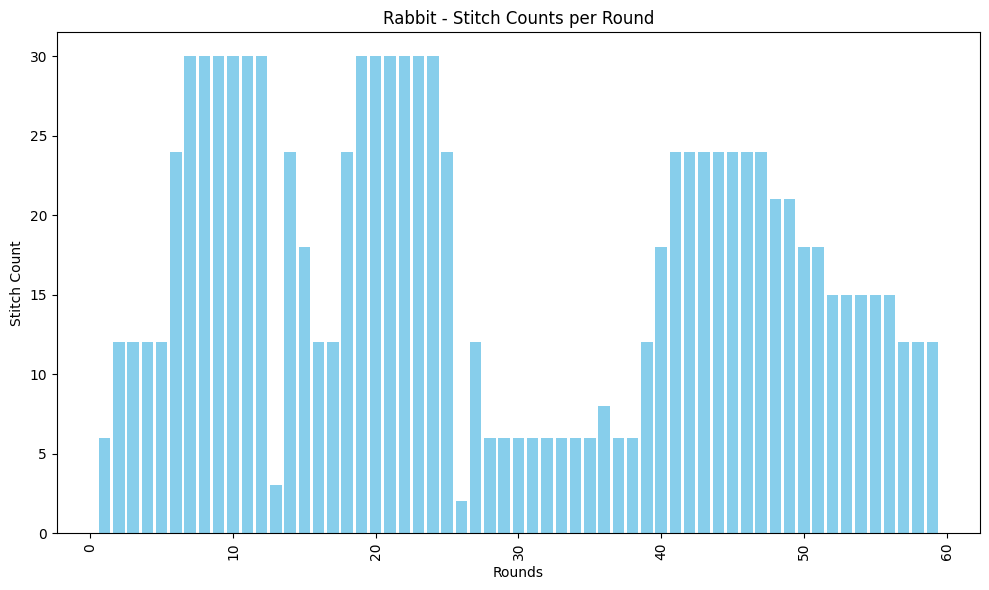

In [463]:
plt.figure(figsize=(10, 6))
plt.bar(df_rabbit['round_continuous'], df_rabbit['count'], color='skyblue')
plt.xticks(rotation=90)
plt.title("Rabbit - Stitch Counts per Round")
plt.xlabel("Rounds")
plt.ylabel("Stitch Count")
plt.tight_layout()
plt.show()

In [464]:
# Group rounds by their start of a new 'r1'
graphs = []
current_graph = []
for entry in structured_data:
    if entry['round'] == 1 and current_graph:
        graphs.append(current_graph)
        current_graph = []
    current_graph.append(entry)
if current_graph:
    graphs.append(current_graph)

In [465]:
G = nx.DiGraph()

for entry_idx in range(len(structured_data) - 1):
    if structured_data[entry_idx]['round'] == 1:
        G.add_node(structured_data[entry_idx]['instructions'])

    G.add_edge(
        structured_data[entry_idx]['instructions'],
        structured_data[entry_idx + 1]['instructions']
    )

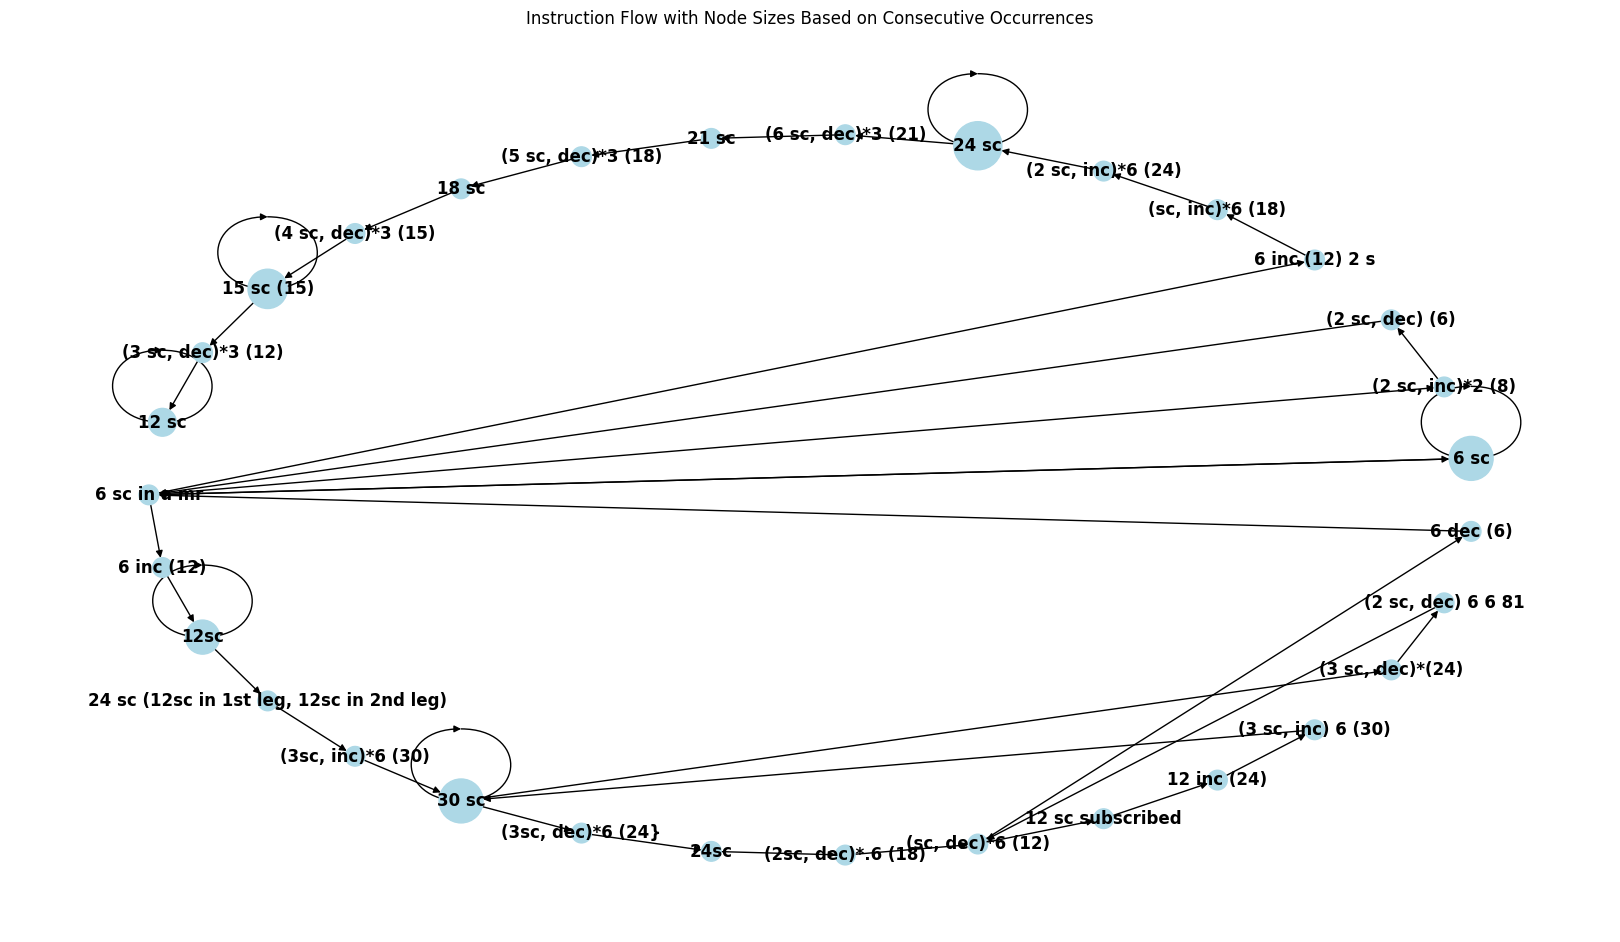

In [467]:
# Count consecutive occurrences of instructions
node_sizes = {}
previous_instruction = None
streak = 1

for entry in structured_data:
    instruction = entry['instructions']
    if instruction == previous_instruction:
        streak += 1
    else:
        streak = 1
    node_sizes[instruction] = max(node_sizes.get(instruction, 0), streak)
    previous_instruction = instruction

# Create the graph
G = nx.DiGraph()
for i in range(len(structured_data) - 1):
    G.add_edge(structured_data[i]['instructions'], structured_data[i + 1]['instructions'])

# Map node sizes based on consecutive occurrences
sizes = [node_sizes[node] * 200 for node in G.nodes()]

# Plot the graph
plt.figure(figsize=(16, 9))
pos = nx.shell_layout(G)
nx.draw(
    G,
    pos,
    with_labels=True,
    node_color='lightblue',
    node_size=sizes,
    font_size=12,
    font_weight='bold'
)
plt.title('Instruction Flow with Node Sizes Based on Consecutive Occurrences')
plt.show()

## króliczek Jula

In [13]:
# Sample OCR results
sample_text = """
himai dolphin ga 2
himatay : dolphiira 2 f
himalayf dolphin 2
himalayf dolphin ba 2
himalayf dolphin 82 :
himalayf dolphin bla 2
evai mlphin
himalayf dolphin ba 2
g owa head
r1: 6 in mr (6)
r2: inc*6 (12)
r3: (1sc, inc)*6 (18)
r4: (2sc, inc)*6 (24)
r5: (3sc, inc)*6 (30)
r6 : ( 4 sc , inc ) 6 ( 36 )
r7: (5sc, inc)*6 (42)
r8-13: sc in each (42)
r14: (5sc, dec)*6 (36)
r15: (4sc, dec)*6 (30)
r15: (4sc, dec)*6 (30)
r16: (3sc, dec)*6 (24)
r16: (3sc, dec)*6 (24)
r17: (2sc, dec)*6 (18)
raczka 2 arm 2
r1: 6 in mr (6)
r2: inc*6 (12)
r3-11: sc in each (12)
wypychamy stuff
r12: (isc, dec) (9)
r12: (isc, dec) (9)
zaka czamy sl st ucinamy d uzsz nitk do p niejszego przyszycia
zaka czamy sl st ucinamy d uzsz nitk do po niejszego przyszycia
zaka czamy sl st ucinamy d uzsz nitk do p niejszego przyszycia
zszywamy otw r sewing the hook
wamyon s 2 ng thehole
noga 2 leg 2
r1: 6 in mr (6)
r2: inc*6 (12)
r3: (isc, inc)*6 (18)
r4-7: sc in each (18)
zaka czamy sl st
rrzypri in drugiej second nbpzeg nie ucinamy nitki na kt rej we dont cut th 2 worki g rraguyer
i the second przy drugiej nbpzeg nie ucinamy nitki na kt rej we don t cut the worki g rrguyer
rrzyhpri in drugiej second nbpzeg nie ucinamy nitki na kt rej we dont cut th 2 worki g rrguyer
tu w body
r8: ch1 na 2 nodze, 18 sc na nodze, sc in ch1, r8 s4 8are nopze (38)st = on leg- leg, sc in ch1, 18 sc on 2nd leg (38)
r9: inc, 9sc, inc, 8sc, inc, 9sc;inc, 8sc (42)
r10-12: sc in each (42)
rio 12 : sc in each ( 42 )
r13: (dec, 5sc)*6 (36)
r14: sc in each (36)
r15: (dec, 4sc)*6 (30)
r16: sc in each (30)
r17: (dec, 3sc)*6 (24)
r18: sc in each (24)
ri 8 : sc in each ( 24 )
r18: sc in each (24)
ri 8 : sc in each ( 24 )
r19: (dec, 2sc)*6 (18)
r20-21: sc in each (18)
zaka czamy sl st ucinamy d uzsz nitk do p niejszego przyszycia
ogon tail
r1: 6 in mr (6)
r2: inc*6 (12)
r3: sc in each (12)
r4: (isc, dec)*3 (9)
zaka czamy sl st ucinamy d uzsz nitk do p niejszego przyszycia
uszy 2 yarn 2
r1: 6 in mr (6)
r2: inc*6 (12)
r3: (isc, inc)*6 (18)
r4: sc in each (18)
r5: (2sc, inc)*6 (24)
r6-8: sc in each (24)
r9: (dec, 1osc)*2 (22)
r10: sc in each (22)
r11 : ( dec , 9 sc ) 2 ( 20 )
r12: sc in each (20)
r12: sc in each (20)
r13: (dec 8sc) (18)
r14: sc in each (18)
r15: (dec, 7sc)*2 (16)
r15: (dec, 7sc)*2 (16)
r16: sc in each (16)
r17 : ( dec , 6 sc ) 2 ( 14 )
r18: sc in each (14)
r18: sc in each (14)
r18: sc in each (14)
r19: (dec, 5sc)*2 (12)
r19: (dec, 5sc)*2 (12)
r20: sc in each (12)
r21: (dec, 4sc)*2 (10)
r22: sc in each (10)
"""

In [14]:
structured_output = rabbit_pl_clean_and_structure_data(sample_text)

In [470]:
round_stats = []

for round_ in structured_output:
    instructions = round_['instructions']
    
    # Handle exceptions where the instructions include nested counts in parentheses
    if "sc" in instructions and "(" in instructions and ")" in instructions:
        round_stats.append({
            'round': round_['round_continuous'],
            'total_stitches': 0,  # Assume stitches are directly included in the count
            'total_increases': 0,  # No explicit increases or decreases to count
            'total_decreases': 0,
            'total_count': round_['count']  # Use the provided count
        })
        continue
    
    # Parse the normal instructions
    total_stitches = sum(map(int, re.findall(r'(\d+)\s*sc', round_['instructions'])))
    total_increases = sum(map(int, re.findall(r'(\d+)\s*inc', round_['instructions'])))
    total_decreases = sum(map(int, re.findall(r'(\d+)\s*dec', round_['instructions'])))
    
    round_stats.append({
        'round': round_['round_continuous'],
        'total_stitches': total_stitches,
        'total_increases': total_increases,
        'total_decreases': total_decreases,
        'total_count': round_['count']
    })

In [472]:
filtered_data = [value.get('total_count') for value in round_stats if value.get('total_count') is not None]
max_stitches = max(round_stats, key=lambda x: x.get('total_stitches', 0) or 0)

# Find the round with the minimum total_stitches
min_stitches = min(round_stats, key=lambda x: x.get('total_stitches', 0) or 0)


# Find max and min
max_value = max(filtered_data)
min_value = min(filtered_data)

In [473]:
total_rounds = len(round_stats)
max_stitches = max(round_stats, key=lambda x: x.get('total_stitches', 0) or 0)
min_stitches = min(round_stats, key=lambda x: x.get('total_stitches', 0) or 0)
increase_stats = Counter([stat['total_increases'] for stat in round_stats])
decrease_stats = Counter([stat['total_decreases'] for stat in round_stats])
filtered_count = [value.get('total_count') for value in round_stats if value.get('total_count') is not None]


# Output results
print(f"Total rounds: {total_rounds}")
print(f"Round with maximum stitches: {max_stitches}")
print(f"Round with minimum stitches: {min_stitches}")
print(f"Increase frequency distribution: {increase_stats}")
print(f"Decrease frequency distribution: {decrease_stats}")

Total rounds: 82
Round with maximum stitches: {'round': 40, 'total_stitches': 34, 'total_increases': 0, 'total_decreases': 0, 'total_count': 42}
Round with minimum stitches: {'round': 1, 'total_stitches': 0, 'total_increases': 0, 'total_decreases': 0, 'total_count': 6}
Increase frequency distribution: Counter({0: 82})
Decrease frequency distribution: Counter({0: 82})


In [474]:
# Calculate aggregate stats with exceptions
aggregate_stats = rabbit_calculate_aggregate_stats_with_exceptions(structured_output)

# Output
print(aggregate_stats)

{'total_stitches': 34, 'total_increases': 0, 'total_decreases': 0, 'total_count': 1717}


In [475]:
df_kroliczek = pd.DataFrame(structured_output)

# Ensure `round` is numeric and continuous, and fill missing `count` with NaN
df_kroliczek['round'] = pd.to_numeric(df_kroliczek['round'], errors='coerce')
df_kroliczek['round_continuous'] = pd.to_numeric(df_kroliczek['round_continuous'], errors='coerce')
df_kroliczek['count'] = pd.to_numeric(df_kroliczek['count'], errors='coerce')

# Sort data by round and remove duplicates (keeping the first occurrence)
df_kroliczek = df_kroliczek.sort_values('round_continuous')

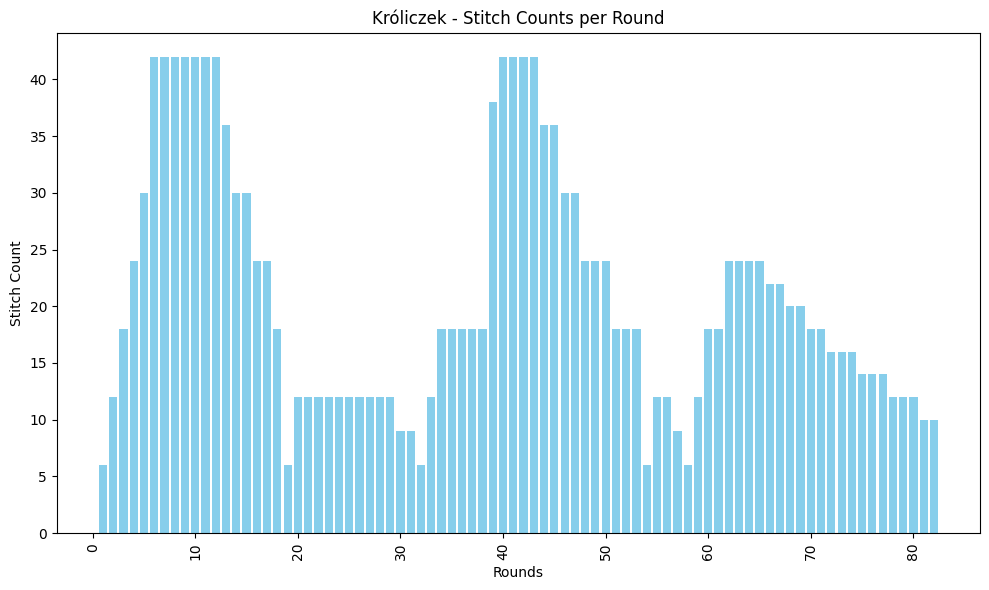

In [476]:
plt.figure(figsize=(10, 6))
plt.bar(df_kroliczek['round_continuous'], df_kroliczek['count'], color='skyblue')
plt.xticks(rotation=90)
plt.title("Króliczek - Stitch Counts per Round")
plt.xlabel("Rounds")
plt.ylabel("Stitch Count")
plt.tight_layout()
plt.show()

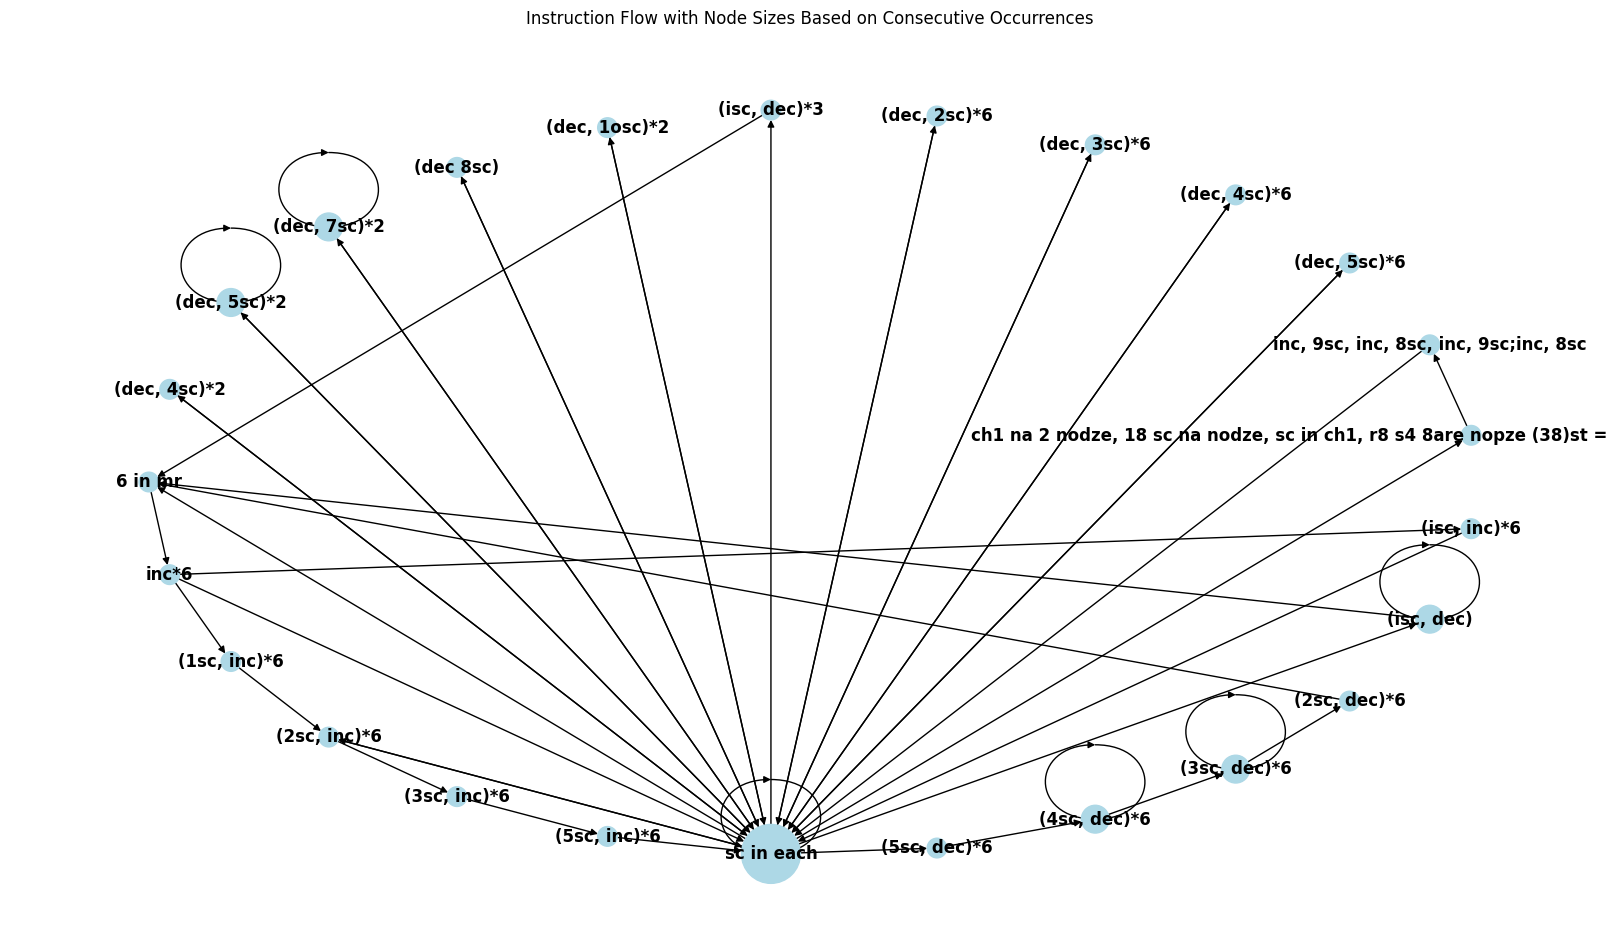

In [481]:
# Count consecutive occurrences of instructions
node_sizes = {}
previous_instruction = None
streak = 1

for entry in structured_output:
    instruction = entry['instructions']
    if instruction == previous_instruction:
        streak += 1
    else:
        streak = 1
    node_sizes[instruction] = max(node_sizes.get(instruction, 0), streak)
    previous_instruction = instruction

# Create the graph
G = nx.DiGraph()
for i in range(len(structured_output) - 1):
    G.add_edge(structured_output[i]['instructions'], structured_output[i + 1]['instructions'])

# Map node sizes based on consecutive occurrences
sizes = [node_sizes[node] * 200 for node in G.nodes()]

# Plot the graph
plt.figure(figsize=(16, 9))
pos = nx.shell_layout(G)
nx.draw(
    G,
    pos,
    with_labels=True,
    node_color='lightblue',
    node_size=sizes,
    font_size=12,
    font_weight='bold'
)
plt.title('Instruction Flow with Node Sizes Based on Consecutive Occurrences', )
plt.show()

## króliczek original

In [16]:
# Input data (sample)
sample_text = """
Głowa
R1: 6 in mr (6)
R2: inc x6 (12)
R3: (1sc, inc) x6 (18)
R4: (2sc, inc) x6 (24)
R5: (3sc, inc) x6 (30)
R6: (4sc, inc) x6 (36)
R7: (5sc, inc) x6 (42)
R8-13: sc in each (42)
R14: (5sc, dec) x6 (36)
R15: (4sc, dec) x6 (30)
R16: (3sc, dec) x6 (24)
R17: (2sc, dec) x6 (18)
zakańczamy slst (zostawiamy dłuższą nitkę która potem wpleciemy w robótkę)

Rączka x2
R1: 6 in mr (6)
R2: inc x6 (12)
R3-11: sc in each (12)
wypychamy
R12: (1sc, dec) (9)
zakańczamy slst (ucinamy dłuższą nitkę do późniejszego przyszycia)
zszywamy otwór

Noga x2
R1: 6 in mr (6)
R2: inc x6 (12)
R3: (1sc, inc) x6 (18)
R4-7: sc in each (18)
zakańczamy sls
przy drugiej nodze nie ucinamy nitki na której pracujemy!!!

Tułów
R8: ch1 na 2 nodze, 18sc na 1 nodze, sc in ch1, 18sc na 2 nodze (38)
R9: inc, 9sc, inc, 8sc, inc, 9sc, inc, 8sc (42)
R10-12: sc in each (42)
R13: (dec, 5sc) x6 (36)
R14: sc in each (36)
R15: (dec, 4sc) x6 (30)
R16: sc in each (30)
R17: (dec, 3sc) x6 (24)
R18: sc in each (24)
R19: (dec, 2sc) x6 (18)
R20-21: sc in each (18)
zakańczamy slst, ucinamy dłuższą nitkę do późniejszego przyszycia

Ogon
R1: 6 in mr (6)
R2: inc x6 (12)
R3: sc in each (12)
R4: (1sc, dec) x3 (9)
zakańczamy slst, ucinamy dłuższą nitkę do późniejszego przyszycia

Uszy x2
R1: 6 in mr (6)
R2: inc x6 (12)
R3: (1sc, inc) x6 (18)
R4: sc in each (18)
R5: (2sc, inc) x6 (24)
R6-8: sc in each (24)
R9: (dec, 10sc) x2 (22)
R10: sc in each (22)
R11: (dec, 9sc) x2 (20)
R12: sc in each (20)
R13: (dec, 8sc) x2 (18)
R14: sc in each (18)
R15: (dec, 7sc) x2 (16)
R16: sc in each (16)
R17: (dec, 6sc) x2 (14)
R18: sc in each (14)
R19: (dec, 5sc) x2 (12)
R20: sc in each (12)
R21: (dec, 4sc) x2 (10)
R22: sc in each (10)
zakańczamy slst, ucinamy dłuższa nitkę do późniejszego przyszycia
zszywamy otwór

Modelowanie głowy
umieszczamy między 11 i 12 rzędem, 6 widocznych oczek między sobą
dodajemy rumieńce
modelujemy pyszczek
wypychamy
zaciskamy niteczki i związujemy
chowamy je
haftujemy nosek
wypychamy ciało
wypychamy ogonek
zszyj wszystkie elementy ze sobą
królik gotowy
"""


In [17]:
result = rabbit_pl_original_clean_and_structure(sample_text)


In [484]:
df_kroliczek_original = pd.DataFrame(result)

# Ensure `round` is numeric and continuous, and fill missing `count` with NaN
df_kroliczek_original['round'] = pd.to_numeric(df_kroliczek_original['round'], errors='coerce')
df_kroliczek_original['round_continuous'] = pd.to_numeric(df_kroliczek_original['round_continuous'], errors='coerce')
df_kroliczek_original['count'] = pd.to_numeric(df_kroliczek_original['count'], errors='coerce')

# Sort data by round and remove duplicates (keeping the first occurrence)
df_kroliczek_original = df_kroliczek_original.sort_values('round_continuous')

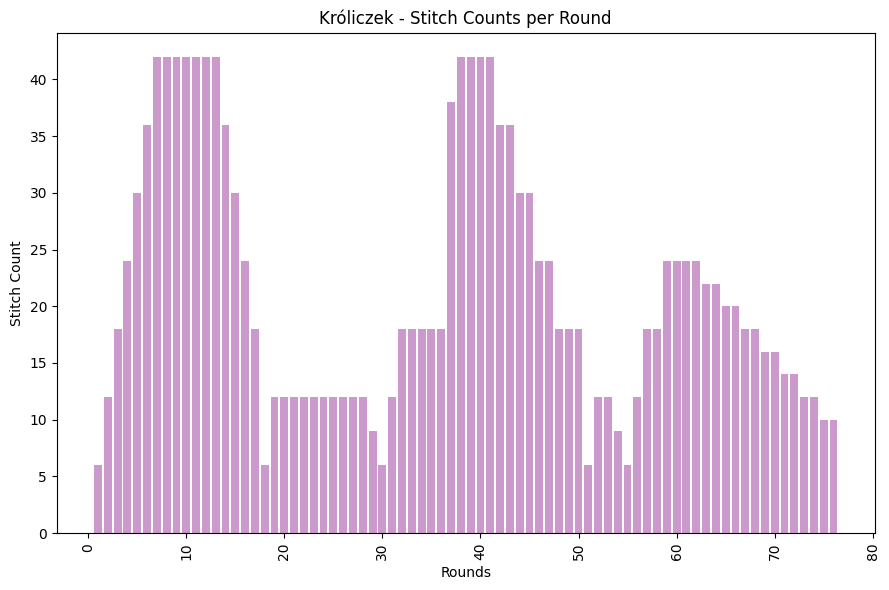

In [488]:
plt.figure(figsize=(9, 6))
plt.bar(df_kroliczek_original['round_continuous'], df_kroliczek_original['count'], color='purple', alpha=0.4)
plt.xticks(rotation=90)
plt.title("Króliczek - Stitch Counts per Round")
plt.xlabel("Rounds")
plt.ylabel("Stitch Count")
plt.tight_layout()
plt.show()

### comaprison

In [489]:
# Compare based on specific keys
keys_to_compare = ['round_continuous', 'instructions', 'count']
similar, diff1, diff2 = partial_compare(structured_output, result, keys_to_compare)

# Output results
print("Similarities:", [dict(t) for t in similar])
print("In list1 but not in list2:", [dict(t) for t in diff1])
print("In list2 but not in list1:", [dict(t) for t in diff2])

Similarities: [{'round_continuous': 36, 'instructions': 'sc in each', 'count': 18}, {'round_continuous': 11, 'instructions': 'sc in each', 'count': 42}, {'round_continuous': 10, 'instructions': 'sc in each', 'count': 42}, {'round_continuous': 9, 'instructions': 'sc in each', 'count': 42}, {'round_continuous': 28, 'instructions': 'sc in each', 'count': 12}, {'round_continuous': 24, 'instructions': 'sc in each', 'count': 12}, {'round_continuous': 1, 'instructions': '6 in mr', 'count': 6}, {'round_continuous': 26, 'instructions': 'sc in each', 'count': 12}, {'round_continuous': 8, 'instructions': 'sc in each', 'count': 42}, {'round_continuous': 35, 'instructions': 'sc in each', 'count': 18}, {'round_continuous': 21, 'instructions': 'sc in each', 'count': 12}, {'round_continuous': 25, 'instructions': 'sc in each', 'count': 12}, {'round_continuous': 41, 'instructions': 'sc in each', 'count': 42}, {'round_continuous': 22, 'instructions': 'sc in each', 'count': 12}, {'round_continuous': 27, '

In [21]:
# Calculate similarities
similarity_results = compare_with_similarity(structured_output, result)

# Output results
for res in similarity_results:
    print(res)

{'round_continuous': 1, 'similarity': 1.0, 'list1_instructions': '6 in mr', 'list2_instructions': '6 in mr'}
{'round_continuous': 2, 'similarity': 0.7272727272727273, 'list1_instructions': 'inc*6', 'list2_instructions': 'inc x6'}
{'round_continuous': 3, 'similarity': 0.88, 'list1_instructions': '(1sc, inc)*6', 'list2_instructions': '(1sc, inc) x6'}
{'round_continuous': 4, 'similarity': 0.88, 'list1_instructions': '(2sc, inc)*6', 'list2_instructions': '(2sc, inc) x6'}
{'round_continuous': 5, 'similarity': 0.88, 'list1_instructions': '(3sc, inc)*6', 'list2_instructions': '(3sc, inc) x6'}
{'round_continuous': 6, 'similarity': 0.8, 'list1_instructions': '(5sc, inc)*6', 'list2_instructions': '(4sc, inc) x6'}
{'round_continuous': 7, 'similarity': 0.5217391304347826, 'list1_instructions': 'sc in each', 'list2_instructions': '(5sc, inc) x6'}
{'round_continuous': 8, 'similarity': 1.0, 'list1_instructions': 'sc in each', 'list2_instructions': 'sc in each'}
{'round_continuous': 9, 'similarity': 1

In [22]:
len(result), len(structured_output)

(76, 82)

## FOX

In [23]:
# Sample input (truncated for demonstration)
sample_text = """
yo 8 e ,
g 8 e ,
chunky super chunky plush yarn orange white medium weight yarn black ( eyebrows , nose ) , white ( behind eyes ) yarn used in tail tutorial : hobbii baby snuggle in burnt orange and white
us g 4.5mm crochet hook scissors poly fill yarn needle 12 1 smm safety eyes stitch markers pins
magic ring chain stitch single crochet increase slip stitch decrease
r1: 6 sc in a mr (6)
r2: 6 inc (12)
r3: (3sc, inc)*3 (15)*
colour change
r4-7: 15 sc
r1: 36 sc (15sc in 1st leg, 3sc in ch3, 15sc in 2nd leg, 3sc in ch3)
r2: (5sc, inc) 6 (42)
sew holerbel een legs closed
sew holes beskepn legs closed
sew holes betweer ao toreed
sew holes be pen ehs closed
sew holes between legs closed
r3-7: 42sc
r8: (5sc, dec)*6 (36)
r9: 36sc
r10: (4sc dec)*6 (30)
r11: 30sc
r12: (3sc, dec)*6 (24)
r13: (2sc, dec)*6 (18)
r14: (sc dec)*6 (12)
colour change to wnite
olour change to white
colour change to white
r15: 12 sc
r16: 12 inc (24)
r17: (sc, inc)*12 (36)
r18: (5sc, inc)*6 (42)
r19: (6sc, inc)*6 (48)
r20-21: 48sc 
r22-24: 48sc
r25: (6sc, dec)*6 (42) 
r26: (5sc, dec)*6 (36)
r27: (4sc, dec)*6 (30)
r28: (3sc, dec)*6 (24)
r29: (2sc, dec)*6 (18)
r30: (sc, dec)*6 (12)
r31: 6 dec (6)
r1: 6 sc in a mr (6)
r2: 6 inc (12)
r3: (sc, inc)*6 (18)
r4: 18sc (18)
r1: 6 sc in a mr 
r2: 6 inc (12)
r3: 12 sc
colour change to orange
colour change to orany
colour change to orange
r4: (2sc, dec)*3 (9)
r5-8: 9 sc
r1: 4 sc in a mr
r2: 4 inc (8)
r3: (sc, inc)*4 (12)
r4: (2 sc, inc) (16)
r5: (3 sc, inc)*4 (20)
r6: 20 sc (20)
r1: 4sc in a mr
r2: 4 inc (8)
r3: 8 sc
r4: (sc, inc)*4 (12)
colour change to orange
r5-8: 12 sc
stuff
r9: (sc, dec)*4 (8)
r10: (2sc, dec)*2 (6)
assembly
subscribed
tl
roseandlilyamigurumicom
roseavdlilyamigurumi com
"""

In [25]:
output = fox_clean_and_parse(sample_text)

In [508]:
round_stats = []

for round_ in output:
    instructions = round_['instructions']
    
    # Handle exceptions where the instructions include nested counts in parentheses
    if "sc" in instructions and "(" in instructions and ")" in instructions:
        round_stats.append({
            'round': round_['round_continuous'],
            'total_stitches': 0,  # Assume stitches are directly included in the count
            'total_increases': 0,  # No explicit increases or decreases to count
            'total_decreases': 0,
            'total_count': round_['count']  # Use the provided count
        })
        continue
    
    # Parse the normal instructions
    total_stitches = sum(map(int, re.findall(r'(\d+)\s*sc', round_['instructions'])))
    total_increases = sum(map(int, re.findall(r'(\d+)\s*inc', round_['instructions'])))
    total_decreases = sum(map(int, re.findall(r'(\d+)\s*dec', round_['instructions'])))
    
    round_stats.append({
        'round': round_['round_continuous'],
        'total_stitches': total_stitches,
        'total_increases': total_increases,
        'total_decreases': total_decreases,
        'total_count': round_['count']
    })

In [509]:
filtered_data = [value.get('total_count') for value in round_stats if value.get('total_count') is not None]
max_stitches = max(round_stats, key=lambda x: x.get('total_stitches', 0) or 0)

# Find the round with the minimum total_stitches
min_stitches = min(round_stats, key=lambda x: x.get('total_stitches', 0) or 0)


# Find max and min
max_value = max(filtered_data)
min_value = min(filtered_data)

In [510]:
total_rounds = len(round_stats)
max_stitches = max(round_stats, key=lambda x: x.get('total_stitches', 0) or 0)
min_stitches = min(round_stats, key=lambda x: x.get('total_stitches', 0) or 0)
increase_stats = Counter([stat['total_increases'] for stat in round_stats])
decrease_stats = Counter([stat['total_decreases'] for stat in round_stats])
filtered_count = [value.get('total_count') for value in round_stats if value.get('total_count') is not None]


# Output results
print(f"Total rounds: {total_rounds}")
print(f"Round with maximum stitches: {max_stitches}")
print(f"Round with minimum stitches: {min_stitches}")
print(f"Increase frequency distribution: {increase_stats}")
print(f"Decrease frequency distribution: {decrease_stats}")

Total rounds: 66
Round with maximum stitches: {'round': 27, 'total_stitches': 48, 'total_increases': 0, 'total_decreases': 0, 'total_count': 48}
Round with minimum stitches: {'round': 2, 'total_stitches': 0, 'total_increases': 6, 'total_decreases': 0, 'total_count': 12}
Increase frequency distribution: Counter({0: 60, 6: 3, 4: 2, 12: 1})
Decrease frequency distribution: Counter({0: 65, 6: 1})


In [511]:
df_fox = pd.DataFrame(output)

# Ensure `round` is numeric and continuous, and fill missing `count` with NaN
df_fox['round'] = pd.to_numeric(df_fox['round'], errors='coerce')
df_fox['round_continuous'] = pd.to_numeric(df_fox['round_continuous'], errors='coerce')
df_fox['count'] = pd.to_numeric(df_fox['count'], errors='coerce')

# Sort data by round and remove duplicates (keeping the first occurrence)
df_fox = df_fox.sort_values('round_continuous')

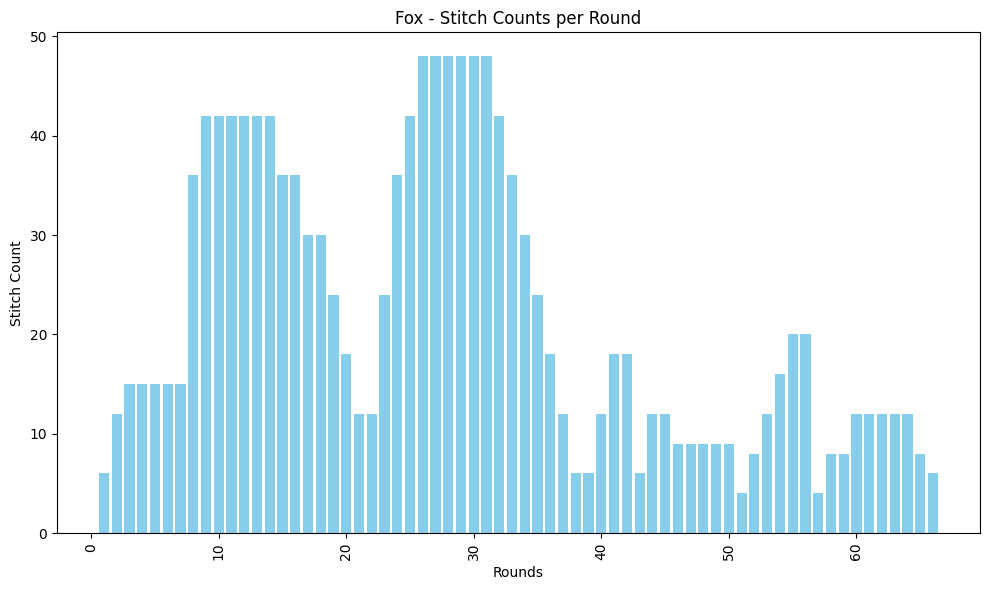

In [512]:
plt.figure(figsize=(10, 6))
plt.bar(df_fox['round_continuous'], df_fox['count'], color='skyblue')
plt.xticks(rotation=90)
plt.title("Fox - Stitch Counts per Round")
plt.xlabel("Rounds")
plt.ylabel("Stitch Count")
plt.tight_layout()
plt.show()

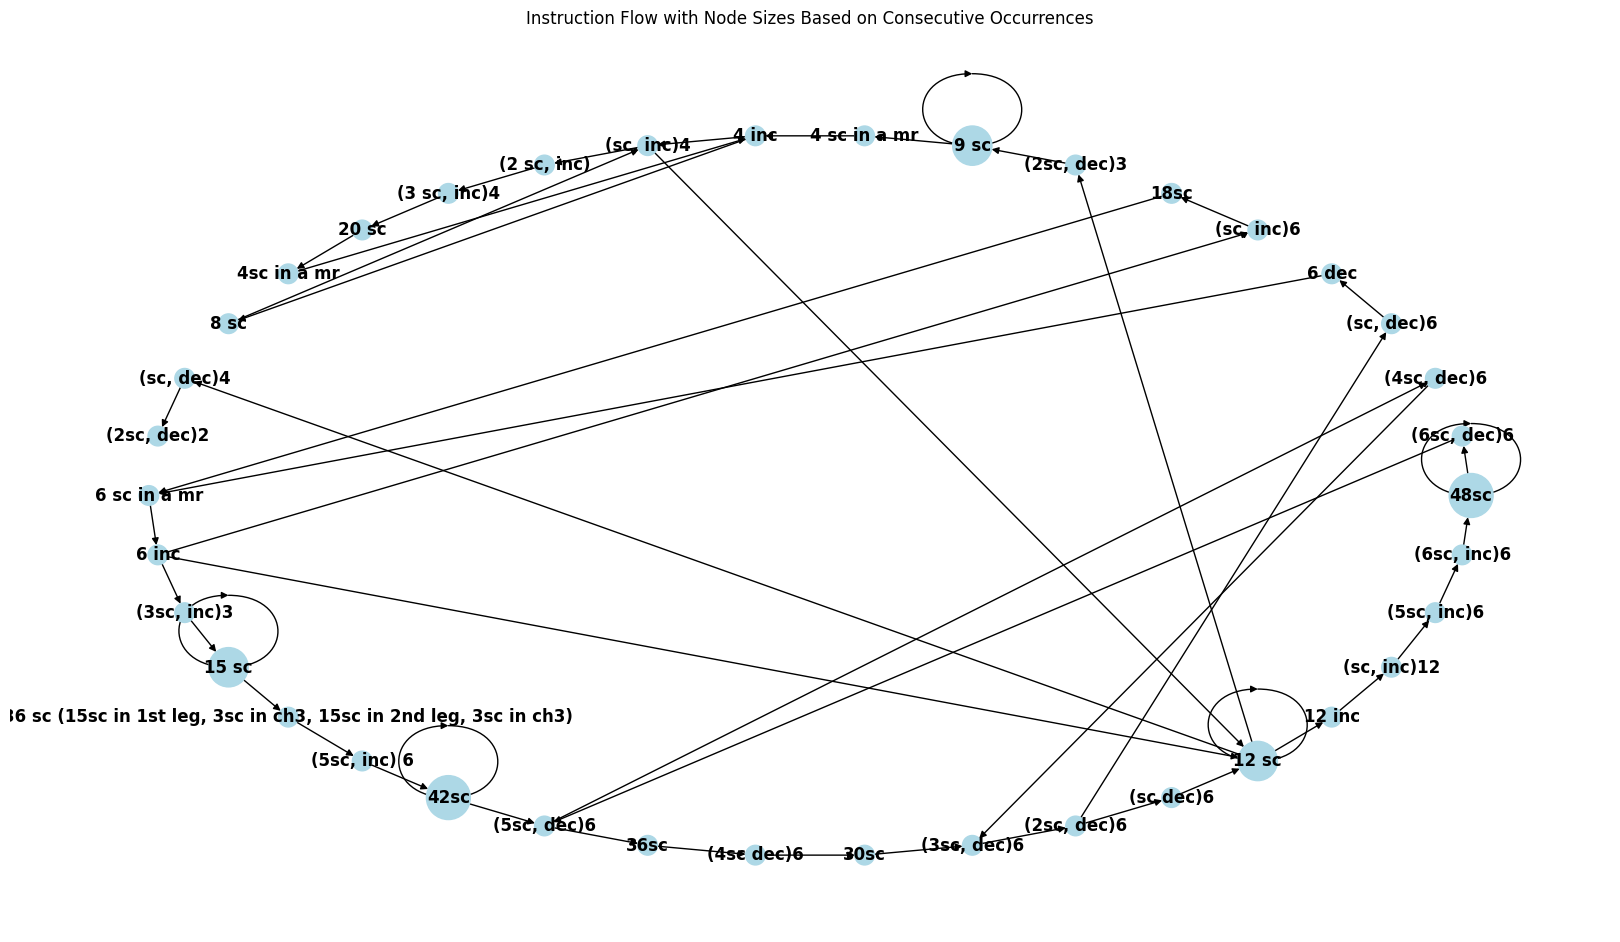

In [513]:
# Count consecutive occurrences of instructions
node_sizes = {}
previous_instruction = None
streak = 1

for entry in output:
    instruction = entry['instructions']
    if instruction == previous_instruction:
        streak += 1
    else:
        streak = 1
    node_sizes[instruction] = max(node_sizes.get(instruction, 0), streak)
    previous_instruction = instruction

# Create the graph
G = nx.DiGraph()
for i in range(len(output) - 1):
    G.add_edge(output[i]['instructions'], output[i + 1]['instructions'])

# Map node sizes based on consecutive occurrences
sizes = [node_sizes[node] * 200 for node in G.nodes()]

# Plot the graph
plt.figure(figsize=(16, 9))
pos = nx.shell_layout(G)
nx.draw(
    G,
    pos,
    with_labels=True,
    node_color='lightblue',
    node_size=sizes,
    font_size=12,
    font_weight='bold'
)
plt.title('Instruction Flow with Node Sizes Based on Consecutive Occurrences', )
plt.show()

## renifer

In [26]:

# Input sample text
sample_text = """
g owa
r1: 6 in mr [6]
r2: inc*6 [12]
r3: (1sc, inc)*6 [18]
r4: (2sc, inc)*6 [24]
r5: (3sc, inc)*6 [30]
r6: (4 sc, inc)*6 [36]
r7-8: sc in each [36]
r9: (5sc, inc)*6 [42]
r10-14: sc in each [42]
r15: (5sc, dec)*6 [36]
r16: (4sc, dec)*6 [30]
r17 : ( 3 sc , dec ) 6 [24]
r18 : ( 2 sc , dec ) *6 [18]
zaka czamy sl st
uszy 2
r1: 3 in mr [3]
r2: inc*3 [6]
r3: inc*6 [12]
r4-6: sc in each [12]
r7: (sc, dec)*4 [8]
pyszczek
r1: 6 in mr [6]
r2: (1sc, 3sc in one)*3 [12]
r3: 2sc, inc, (3sc, inc)*2, sc [15]
r4: sc in each [15]
zaka czamy sl st
rogi 2
r1: 6 in mr [6]
r2-7: sc in each [6]


2 cz rogu
r1: 6 in mr [6]
r2-4: sc in each [6]
zaka czamy sl st
6 zaka czamy sl st
4
wypychamy
przyszywamy mniejsz cz do wi kszej
nogi 2
r1: 6 in mr [6]
r2: (1sc, inc)*3 [9]
r3: sc in each [9]
zmiana kolru
r4: (2sc, inc)*3 [12]
r5: sc in each [12]
r6: (3sc, inc)*3 [15]
r7: sc in each [15]
zaka czamy sl st
przy drugiej nodze nie odcinamy nitki bo b dziemy na niej dalej pracowa
r8: ch1, 15sc na nodze, sc in ch1, 15 sc na drugiej nodze, sc in ch1 [32]
r9: inc, 7sc, inc, 6sc, inc, 7sc, inc, 8sc [36]
r10-11: sc in each [36]
r12: (dec, 4sc)*6 [30]
r13-14: sc in each [30]
r15: (dec, 3sc)*6 [24]
r16: sc in each [24]
r17: (dec, 2sc)*6 [18]
r18: sc in each [18]
zaka czamy sl st
wypychamy
r1: 6 in mr [6]
r2: (sc, inc)*3 [9]
r3: sc in each [9]
r4: sc in each [9]
r5: (2sc, inc)*3 [12]
r5: (2sc, inc)*3 [12]
r6-7 : sc in each 12
r8: (2sc, dec)*3 [9]
r9: (1sc, dec)*3 [6]
r1: 6 in mr [6]
r2: inc*6 [12]
r3: sc, 2hdc inc, 9sc [14]
"""

In [28]:
parsed_result = reindeer_parse_crochet_instructions(sample_text)


In [526]:
round_stats = []

for round_ in parsed_result:
    instructions = round_['instructions']
    
    # Handle exceptions where the instructions include nested counts in parentheses
    if "sc" in instructions and "(" in instructions and ")" in instructions:
        round_stats.append({
            'round': round_['round_continuous'],
            'total_stitches': 0,  # Assume stitches are directly included in the count
            'total_increases': 0,  # No explicit increases or decreases to count
            'total_decreases': 0,
            'total_count': round_['count']  # Use the provided count
        })
        continue
    
    # Parse the normal instructions
    total_stitches = sum(map(int, re.findall(r'(\d+)\s*sc', round_['instructions'])))
    total_increases = sum(map(int, re.findall(r'(\d+)\s*inc', round_['instructions'])))
    total_decreases = sum(map(int, re.findall(r'(\d+)\s*dec', round_['instructions'])))
    
    round_stats.append({
        'round': round_['round_continuous'],
        'total_stitches': total_stitches,
        'total_increases': total_increases,
        'total_decreases': total_decreases,
        'total_count': round_['count']
    })

In [527]:
total_rounds = len(round_stats)
max_stitches = max(round_stats, key=lambda x: x.get('total_stitches', 0) or 0)
min_stitches = min(round_stats, key=lambda x: x.get('total_stitches', 0) or 0)
increase_stats = Counter([stat['total_increases'] for stat in round_stats])
decrease_stats = Counter([stat['total_decreases'] for stat in round_stats])
filtered_count = [value.get('total_count') for value in round_stats if value.get('total_count') is not None]


# Output results
print(f"Total rounds: {total_rounds}")
print(f"Round with maximum stitches: {max_stitches}")
print(f"Round with minimum stitches: {min_stitches}")
print(f"Increase frequency distribution: {increase_stats}")
print(f"Decrease frequency distribution: {decrease_stats}")

Total rounds: 67
Round with maximum stitches: {'round': 46, 'total_stitches': 30, 'total_increases': 0, 'total_decreases': 0, 'total_count': 32}
Round with minimum stitches: {'round': 1, 'total_stitches': 0, 'total_increases': 0, 'total_decreases': 0, 'total_count': 6}
Increase frequency distribution: Counter({0: 67})
Decrease frequency distribution: Counter({0: 67})


In [528]:
df_reindeer = pd.DataFrame(parsed_result)

# Ensure `round` is numeric and continuous, and fill missing `count` with NaN
df_reindeer['round_continuous'] = pd.to_numeric(df_reindeer['round_continuous'], errors='coerce')
df_reindeer['round'] = pd.to_numeric(df_reindeer['round'], errors='coerce')
df_reindeer['count'] = pd.to_numeric(df_reindeer['count'], errors='coerce')

# Sort data by round and remove duplicates (keeping the first occurrence)
df_reindeer = df_reindeer.sort_values('round_continuous')

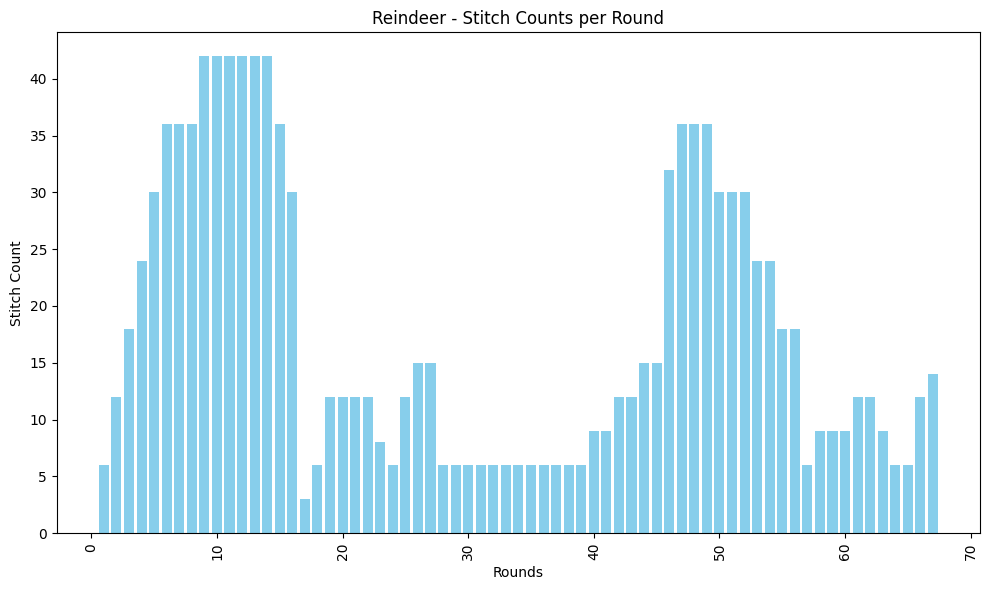

In [529]:
plt.figure(figsize=(10, 6))
plt.bar(df_reindeer['round_continuous'], df_reindeer['count'], color='skyblue')
plt.xticks(rotation=90)
plt.title("Reindeer - Stitch Counts per Round")
plt.xlabel("Rounds")
plt.ylabel("Stitch Count")
plt.tight_layout()
plt.show()

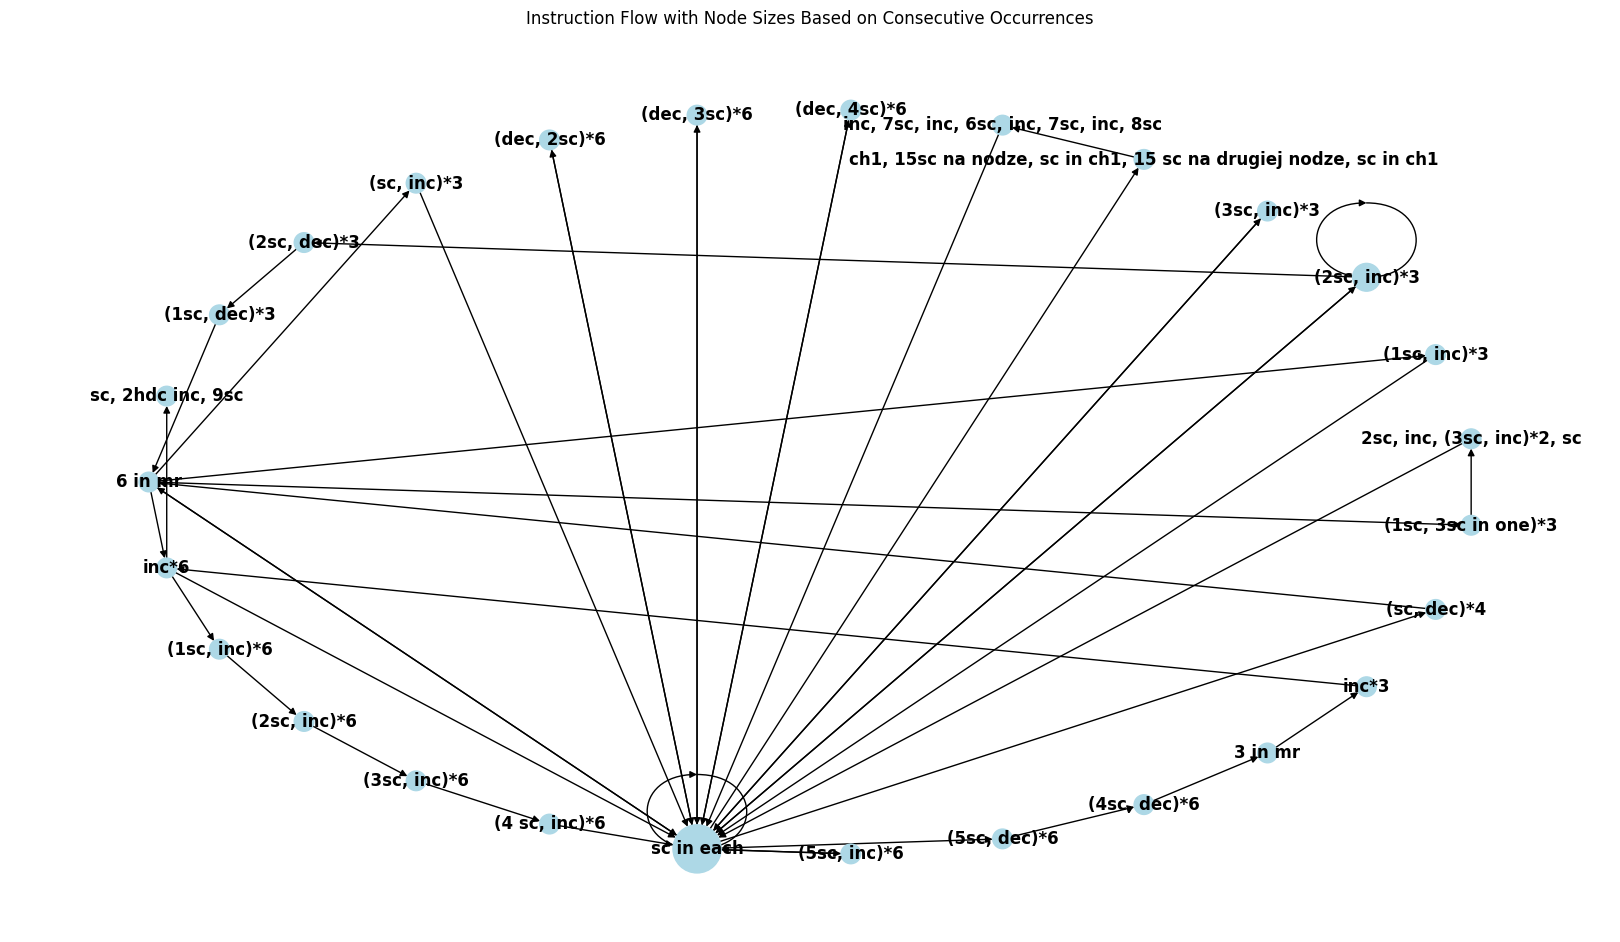

In [530]:
# Count consecutive occurrences of instructions
node_sizes = {}
previous_instruction = None
streak = 1

for entry in parsed_result:
    instruction = entry['instructions']
    if instruction == previous_instruction:
        streak += 1
    else:
        streak = 1
    node_sizes[instruction] = max(node_sizes.get(instruction, 0), streak)
    previous_instruction = instruction

# Create the graph
G = nx.DiGraph()
for i in range(len(parsed_result) - 1):
    G.add_edge(parsed_result[i]['instructions'], parsed_result[i + 1]['instructions'])

# Map node sizes based on consecutive occurrences
sizes = [node_sizes[node] * 200 for node in G.nodes()]

# Plot the graph
plt.figure(figsize=(16, 9))
pos = nx.shell_layout(G)
nx.draw(
    G,
    pos,
    with_labels=True,
    node_color='lightblue',
    node_size=sizes,
    font_size=12,
    font_weight='bold'
)
plt.title('Instruction Flow with Node Sizes Based on Consecutive Occurrences', )
plt.show()

## duck

In [29]:
sample_text = """
let s starti
r1: ch 2 and insert 8 sc in the 2nd ch from hook (8)
r2: inc around (16)
r3: (sc; inc)*8 (24)
r4-7: sc around (24)
r8: dec around (12)
r9: inc around (24)
r10: sc 22, inc 2 (26)
r11: sc 23 inc 2, sc; (28) 
r12: sc 24, inc 2, sc 2. (30) 
r13: sc 25, inc 2, sc 3. (32) 
r14: sc around. (32)
r15: (sc, dec)*2. sc 10. (dec; sc)*3. dec 2, sc, dec: (24)
r16: (sc; dec)*8 (16) 
r17: dec around, (8)
"""

# Regex pattern for parsing crochet instructions
pattern = r"r(?P<rounds>[\d]+(?:-[\d]+)?)\s*:\s*(?P<instructions>.+?)\s*\\?\((?P<count>\d+)\\?\)"

# Find all matches
matches = re.finditer(pattern, sample_text)

# Extract and structure data
results = []
round_continuous = 1
for match in matches:
    rounds = match.group("rounds")
    instructions = match.group("instructions").strip()
    count = int(match.group("count")) if match.group("count") else None

    # Handle ranges like r4-r7
    if "-" in rounds:
        start, end = map(int, rounds.split("-"))
        for round_num in range(start, end + 1):
            results.append({
                "round": round_num,
                "round_continuous": round_continuous,
                "instructions": instructions,
                "count": count
            })
            round_continuous += 1
    else:
        results.append({
            "round": int(rounds),
            "round_continuous": round_continuous,
            "instructions": instructions,
            "count": count
        })
        round_continuous += 1

In [540]:
df_duck = pd.DataFrame(results)

# Ensure `round` is numeric and continuous, and fill missing `count` with NaN
df_duck['round_continuous'] = pd.to_numeric(df_duck['round_continuous'], errors='coerce')
df_duck['round'] = pd.to_numeric(df_duck['round'], errors='coerce')
df_duck['count'] = pd.to_numeric(df_duck['count'], errors='coerce')

# Sort data by round and remove duplicates (keeping the first occurrence)
df_duck = df_duck.sort_values('round_continuous')

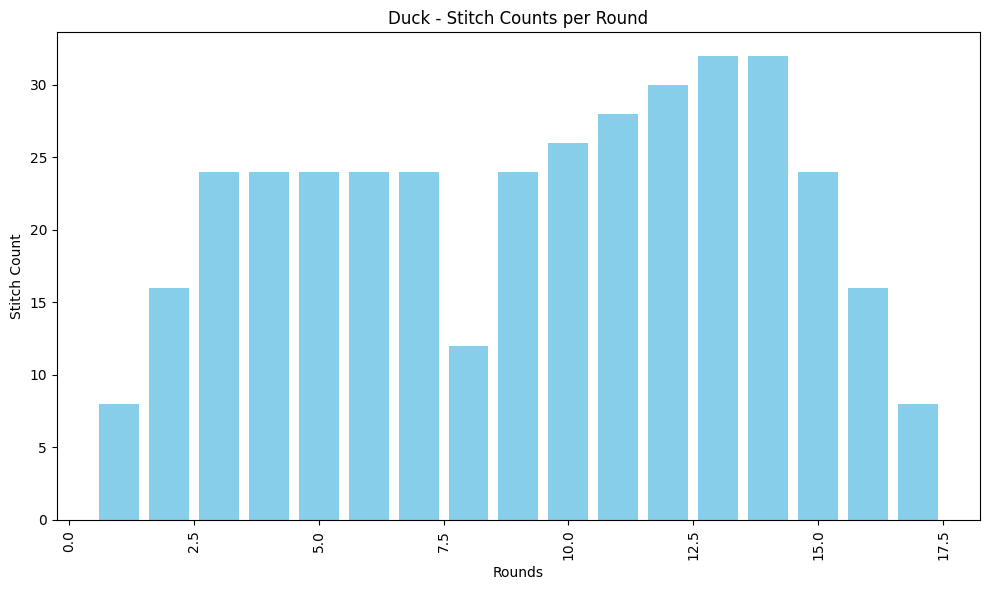

In [541]:
plt.figure(figsize=(10, 6))
plt.bar(df_duck['round_continuous'], df_duck['count'], color='skyblue')
plt.xticks(rotation=90)
plt.title("Duck - Stitch Counts per Round")
plt.xlabel("Rounds")
plt.ylabel("Stitch Count")
plt.tight_layout()
plt.show()

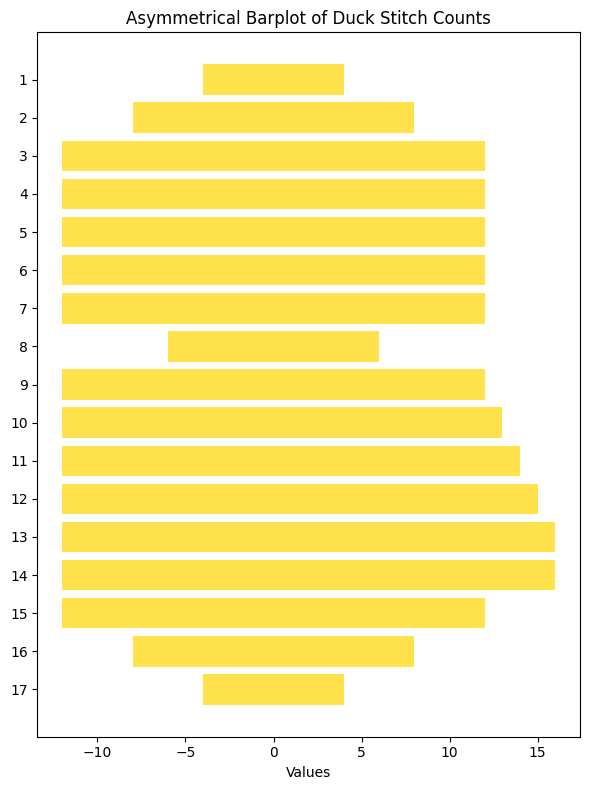

In [598]:
import numpy as np

# Sort data by round descending
sorted_duck = df_duck.sort_values('round_continuous', ascending=False)

# Create separate values for left and right bars
left_values = sorted_duck['count'].copy()/2
right_values = sorted_duck['count'].copy()/2

# Modify the left values for rounds 9 to 14
condition = (sorted_duck['round'] >= 9) & (sorted_duck['round'] <= 15)
left_values[condition] = 12
# Plotting
categories = sorted_duck['round']
positions = np.arange(len(categories))

fig, ax = plt.subplots(figsize=(6, 8))

# Plot right-side bars
ax.barh(positions, right_values, color='gold', label='Right', alpha=0.7, align='center')

# Plot left-side bars
ax.barh(positions, -left_values, color='gold', label='Left', alpha=0.7, align='center')


# Labeling
ax.set_yticks(positions)
ax.set_yticklabels(categories)
ax.set_xlabel('Values')
ax.set_title('Asymmetrical Barplot of Duck Stitch Counts')

# Adjust layout
plt.tight_layout()
plt.show()

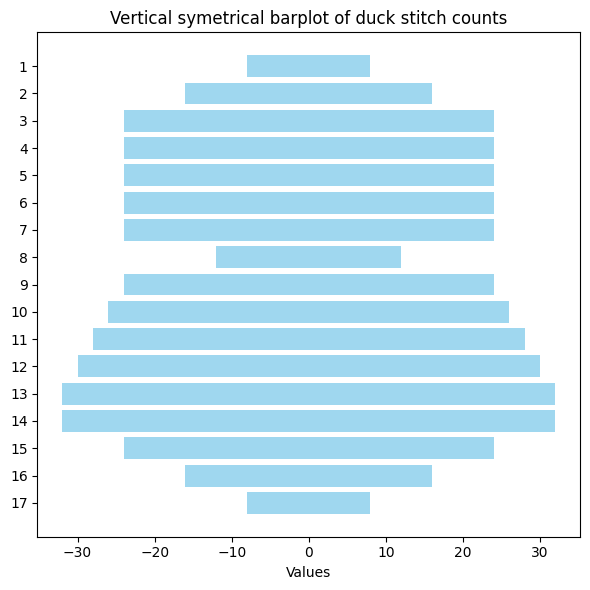

In [546]:
sorted_duck = df_duck.sort_values('round', ascending=False)

# Sample data
categories = sorted_duck['round']
values = sorted_duck['count']

# Create the figure and axis
fig, ax = plt.subplots(figsize=(6, 6))

# Position of the bars on the x-axis
positions = np.arange(len(categories))

# Plot the right-side bars (positive x-axis)
ax.barh(positions, values, color='skyblue', label='Right', alpha=0.8, align='center')

# Plot the left-side bars (negative x-axis) by mirroring the values
ax.barh(positions, [-val for val in values], color='skyblue', label='Left', alpha=0.8, align='center')

# Add a vertical line at x=0 for symmetry
# ax.axvline(0, color='black', linewidth=0.5)

# Labeling
ax.set_yticks(positions)
ax.set_yticklabels(categories)
ax.set_xlabel('Values')
ax.set_title('Vertical symetrical barplot of duck stitch counts')

# Adjust layout
plt.tight_layout()
plt.show()

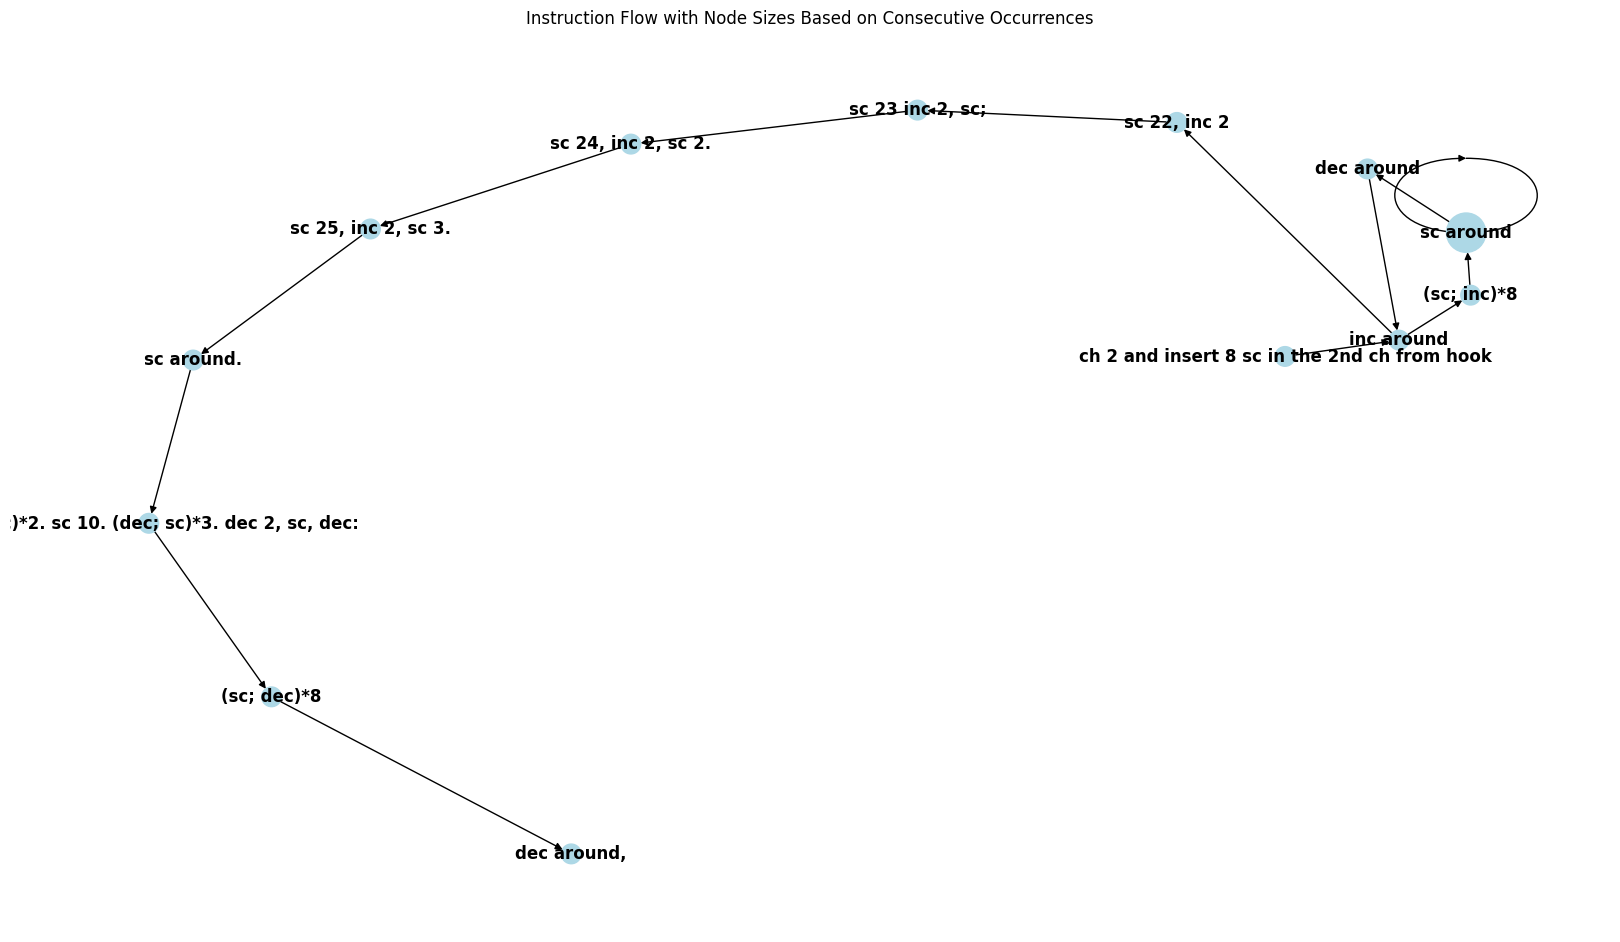

In [599]:
# Count consecutive occurrences of instructions
node_sizes = {}
previous_instruction = None
streak = 1

for entry in results:
    instruction = entry['instructions']
    if instruction == previous_instruction:
        streak += 1
    else:
        streak = 1
    node_sizes[instruction] = max(node_sizes.get(instruction, 0), streak)
    previous_instruction = instruction

# Create the graph
G = nx.DiGraph()
for i in range(len(results) - 1):
    G.add_edge(results[i]['instructions'], results[i + 1]['instructions'])

# Map node sizes based on consecutive occurrences
sizes = [node_sizes[node] * 200 for node in G.nodes()]

# Plot the graph
plt.figure(figsize=(16, 9))
pos = nx.spiral_layout(G)
nx.draw(
    G,
    pos,
    with_labels=True,
    node_color='lightblue',
    node_size=sizes,
    font_size=12,
    font_weight='bold'
)
plt.title('Instruction Flow with Node Sizes Based on Consecutive Occurrences', )
plt.show()

## penguin

In [31]:
import re

# Sample input text
sample_text = """
easy
r1: ch 2 and insert 6 sc in the 2nd ch from hook (6)
r2: (sc 2, inc)*2. (8)
r3: sc around (8)
r4: (sc 3, inc)*2. (10)
r5: sc around, (10)
r6: (sc 4, inc)*2. (12)
r7: sc around; (12)
r8: dec around; (6)

r1: ch 2 and insert 8 sc in the 2nd ch from hook (8)
r2: inc around: (16)
r3: (sc; inc)*8. (24)
r4-8: sc around (24)
r9: (sc 6, dec)*3. (21)
r10: (sc 5, dec)*3. (18)
r11: (sc; dec)*6. (12)
r12: sc 3. pick up one wing; and attach it to the body with 3 sc (insert hook into both layers of wing and body at the same time) : sc 3.attach the second wing with 3 sc. (12)
head
r13: in flo, (sc; inc)*6, (18)
r14: switch to dark grey (dg) and sc 2, inc; sc 2. switch to white and inc; (sc 2, inc)*3. sc 3. switch to dg and insert one sc in the same st as the previous; turning it into an inc: (24)
r15: in dg yarn, sc 7. in white yarn, sc 16. in dg yarn; sc. (24)
r16: in dg yarn; sc 8. in white yarn; sc 7. in dg yarn, sc (stay with white yarn if you do not want dg showing beneath the beak) in white yarn; sc 7. in dg yarn; sc: (24)
r17: in dg, sc 9. in white; sc 6.in dg; sc 2. in white, sc 6. in dg, sc: (24)
r18: in dg, sc 10.in white, sc 5.in dg; sc 3. in white; sc 5.in dg, sc; (24)
r19: in dg, sc 11. in white, sc 4, in dg; sc 4. in white, sc 4, in dg; sc. (24)
r20: (sc 2, dec)*6. (18)
r21: (sc, dec)*6. (12)
r22: dec around. (6)
"""

# Process the sample text
result = penguin_process_crochet_instructions(sample_text)


In [635]:
df_penguin = pd.DataFrame(result)

# Ensure `round` is numeric and continuous, and fill missing `count` with NaN
df_penguin['round'] = pd.to_numeric(df_penguin['round'], errors='coerce')
df_penguin['round_continuous'] = pd.to_numeric(df_penguin['round_continuous'], errors='coerce')
df_penguin['count'] = pd.to_numeric(df_penguin['count'], errors='coerce')

# Sort data by round and remove duplicates (keeping the first occurrence)
df_penguin = df_penguin.sort_values('round_continuous')

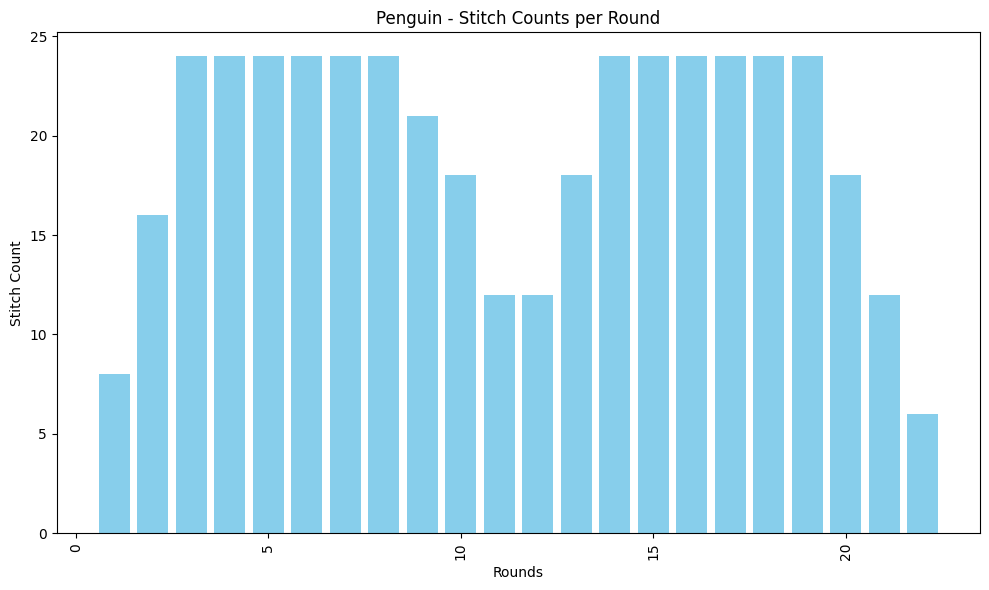

In [636]:
plt.figure(figsize=(10, 6))
plt.bar(df_penguin['round'].astype(int), df_penguin['count'], color='skyblue')
plt.xticks(rotation=90)
plt.title("Penguin - Stitch Counts per Round")
plt.xlabel("Rounds")
plt.ylabel("Stitch Count")
plt.tight_layout()
plt.show()

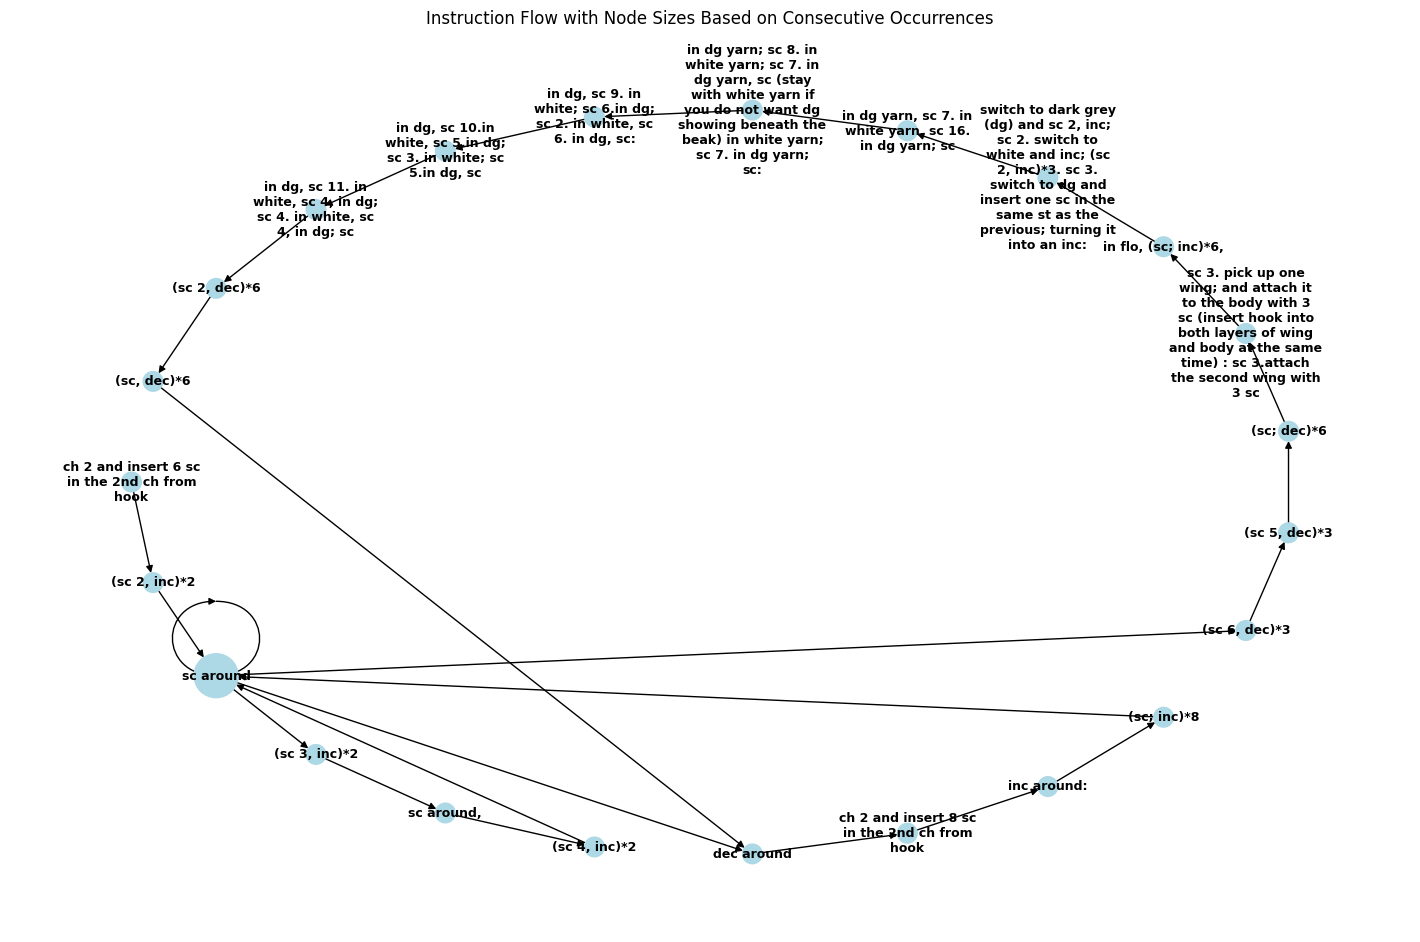

In [642]:
import textwrap

# Helper function to wrap text for node labels
def wrap_text(text, width=20):
    return '\n'.join(textwrap.wrap(text, width))

# Count consecutive occurrences of instructions
node_sizes = {}
previous_instruction = None
streak = 1

for entry in result:
    instruction = entry['instructions']
    if instruction == previous_instruction:
        streak += 1
    else:
        streak = 1
    node_sizes[instruction] = max(
        node_sizes.get(instruction, 0),
        streak
    )
    previous_instruction = instruction

# Create the graph
G = nx.DiGraph()
for i in range(len(result) - 1):
    G.add_edge(
        result[i]['instructions'],
        result[i + 1]['instructions']
    )

# Map node sizes based on consecutive occurrences
sizes = [
    node_sizes[node] * 200
    for node in G.nodes()
]

# Wrap node labels for better readability
labels = {node: wrap_text(node) for node in G.nodes()}

# Plot the graph
plt.figure(figsize=(14, 9))
pos = nx.shell_layout(G)
nx.draw(
    G,
    pos,
    labels=labels,  # Use the wrapped labels
    with_labels=True,
    node_color='lightblue',
    node_size=sizes,
    font_size=9,
    font_weight='bold'
)
plt.title(
    'Instruction Flow with Node Sizes Based on Consecutive Occurrences'
)
plt.show()


## panda

In [32]:
# Sample input text
sample_text = """
himalaya hmialaya jolphin pby dolphin aby
himalaya dolphin br 3 y
alaya 7 aby
himalaya baby
baby hiv izya dolphin baby
ya hiiza aby dolphim bai
himliya dol chain
hivilaya aby
hivalaya aby
hinalaya aby
hin alaya baby
hinalaya baby
hivalaya
hivalaya oic
himalaya
him alaya c
hivlaya
hivalaya gaby
hinalaya baby
hinalaya aby
hinalaya baby
aya saby
hinalya caby
aya caby
pby
himazaya eaby
g owa
r1: 6 in mr [6]
r2: inc*6 [12]
r3: (1sc, inc)*6 [18]
r4: (2sc, inc)*6 [24]
r5: (3sc, inc)*6 [30]
r6: (4 sc, inc) *6 [36]
r7: (5sc, inc)*6 [42]
r8-r13: sc in each [42]
r14: (5sc, dec)*6 [36]
r15: (4sc, dec)*6 [30]
r16: (3sc, dec)*6 [24]
r17: (2sc, dec)*6 [18]
zaka czamy sl st ucinamy nitk
zaka czamy sl st i ucinamy nitk
zaka czamy sl st ucinamy nitk
9
g owa gotowa
uszy 2
r1: 6 in mr [6]
r2: inc*6 [12]
r3: (1sc, inc)*6 [18]
r4-r5: sc in each [18]
zaka czamy sl st ucinamy d u sz nitk
zszywamy otw r
ucho gotowe
r czka 2
r1: 6 in mr [6]
r2: inc*6 [12]
r3-r11: sc in each [12]
r12: (1sc, dec)*4 [8]
zaka czamy sl st ucinamy d u sz nitk
zaka czamy sl st 1 ucinamy d u sz nitk
zaka czamy sl st ucinamy d u sz nitk
zszywamy otw r
r czka gotowa
noga 2
r1: 6 in mr [6]
r2: inc*6 [12]
r3: (1sc, inc)*6 [18]
r4-r7: sc in each [18]
r8: ch1, 18 sc na nodze sc in ch 18 sc na 2 nodze [38]
r9: inc, 9sc, inc, 8sc, inc, 9sc, inc, 8sc [42]
r10-r12: sc in each [42]
r13: (dec, 5sc)*6 [36]
r14: sc in each [36]
r16: sc in each [30]
r17: (dec, 3sc)*6 [24]
zmieniamy kolor na czarny
r18: sc in each [24]
r19: (dec, 2sc)*6 [18]
r20-r21: sc in each [18]
r1: 6 in mr [6]
r2: inc*6 [12]
r3: sc in each [12]
r4: (1sc, dec)*4 [8]
"""

In [34]:
results = panda_extract_instructions(sample_text)

In [577]:
df_panda = pd.DataFrame(results)

# Ensure `round` is numeric and continuous, and fill missing `count` with NaN
df_panda['round_continuous'] = pd.to_numeric(df_panda['round_continuous'], errors='coerce')
df_panda['round'] = pd.to_numeric(df_panda['round'], errors='coerce')
df_panda['count'] = pd.to_numeric(df_panda['count'], errors='coerce')

# Sort data by round and remove duplicates (keeping the first occurrence)
df_panda = df_panda.sort_values('round_continuous')

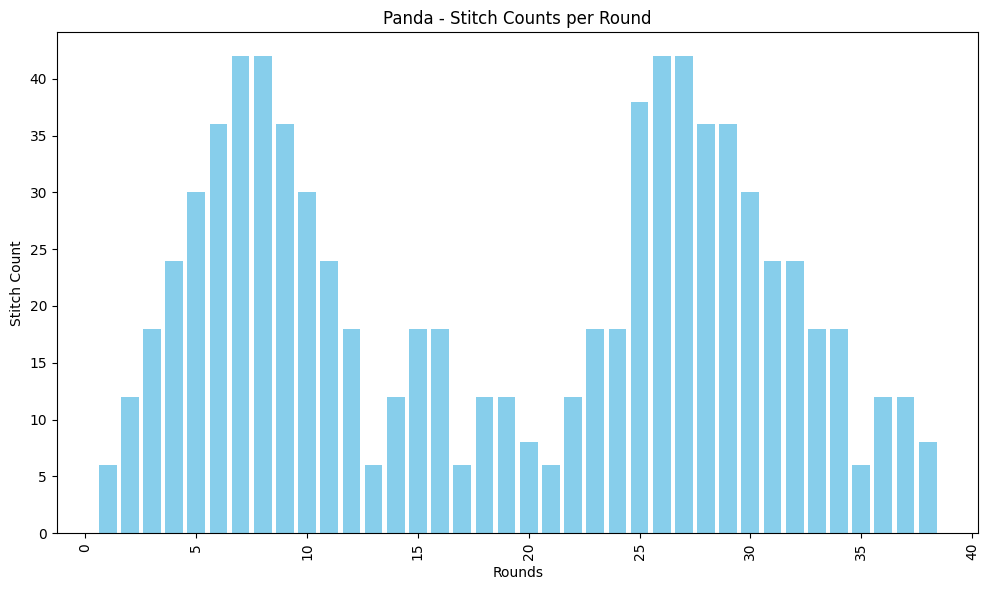

In [578]:
plt.figure(figsize=(10, 6))
plt.bar(df_panda['round_continuous'].astype(int), df_panda['count'], color='skyblue')
plt.xticks(rotation=90)
plt.title("Panda - Stitch Counts per Round")
plt.xlabel("Rounds")
plt.ylabel("Stitch Count")
plt.tight_layout()
plt.show()

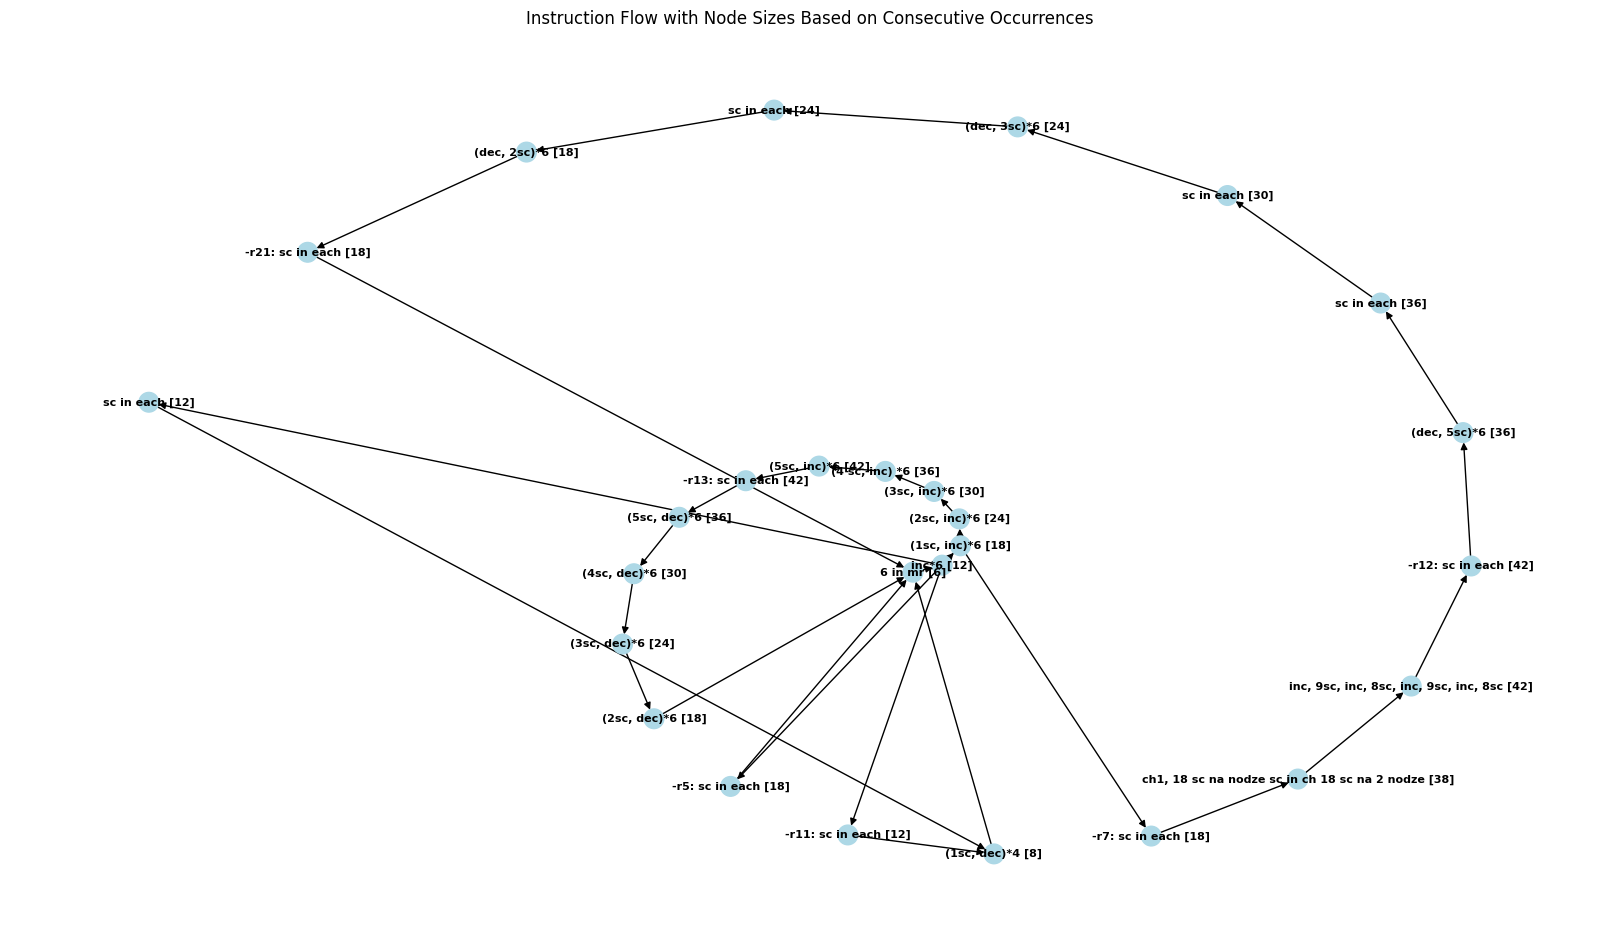

In [579]:
# Count consecutive occurrences of instructions
node_sizes = {}
previous_instruction = None
streak = 1

for entry in results:
    instruction = entry['instructions']
    if instruction == previous_instruction:
        streak += 1
    else:
        streak = 1
    node_sizes[instruction] = max(node_sizes.get(instruction, 0), streak)
    previous_instruction = instruction

# Create the graph
G = nx.DiGraph()
for i in range(len(results) - 1):
    G.add_edge(results[i]['instructions'], results[i + 1]['instructions'])

# Map node sizes based on consecutive occurrences
sizes = [node_sizes[node] * 200 for node in G.nodes()]

# Plot the graph
plt.figure(figsize=(16, 9), facecolor='none')
pos = nx.spiral_layout(G)
nx.draw(
    G,
    pos,
    with_labels=True,
    node_color='lightblue',
    node_size=sizes,
    font_size=8,
    font_weight='bold'
)
plt.title('Instruction Flow with Node Sizes Based on Consecutive Occurrences', )
plt.show()

## pan mis

In [35]:
# Sample unstructured input text
sample_text = """
r1: 6 in mr [6]
r2: inc*6 [12]
r3: (isc, inc)*6 [18]
r4: (2sc, inc)*6 [24]
r5: (3sc, inc)*6 [30]
r6: (4sc, inc)*6 [36]
r7: (5sc, inc)*6 [42]
r8-13: sc in each [42]
r14: (5sc, dec)*6 [36]
r15: (4sc, dec)*6 [30]
r16: (3sc, dec)*6 [24]
r17: (2sc, dec)*6 [18]
r1: 6 in mr [6]
r2: inc*6 [12]
r3: (isc, inc)*6 [18]
r4-5: sc in each [18]
r1 : 6 in mr 6 [6]
r2: inc*6 [12]
r3-11: sc in each [12]
r12: (isc, dec)*4 [8]
r1: 6 in mr [6]
r2: inc*6 [12]
r3: (isc, inc)*6 [18]
r4-7: sc in each [18]
r8: ch1, 18sc na 1 nodze, sc w ch1, 18sc na 2 nodze [28]
r9: inc, 9sc, inc, 8sc, inc, 9sc, inc, 8sc [42]
r10: sc in each [42]
r11-12: sc in each [42]
r13: (dec, 5sc)*6 [36]
r14: blo sc in each [36]
r15: (dec, 4sc)*6 [30]
r16: sc in each [30]
r17: (dec, 3sc)*6 [24]
r18: sc in each [24]
r19: (dec, 2sc)*6 [18]
r20 blo: sc in each [18]
r21: sc in each [18]
""" 

In [37]:
structured_output = mr_bear_clean_and_structure_data(sample_text)

TypeError: 'int' object is not callable

In [653]:
df_panmis = pd.DataFrame(structured_output)

# Ensure `round` is numeric and continuous, and fill missing `count` with NaN
df_panmis['round'] = pd.to_numeric(df_panmis['round'], errors='coerce')
df_panmis['round_continuous'] = pd.to_numeric(df_panmis['round_continuous'], errors='coerce')
df_panmis['count'] = pd.to_numeric(df_panmis['count'], errors='coerce')

# Sort data by round and remove duplicates (keeping the first occurrence)
df_panmis = df_panmis.sort_values('round_continuous')

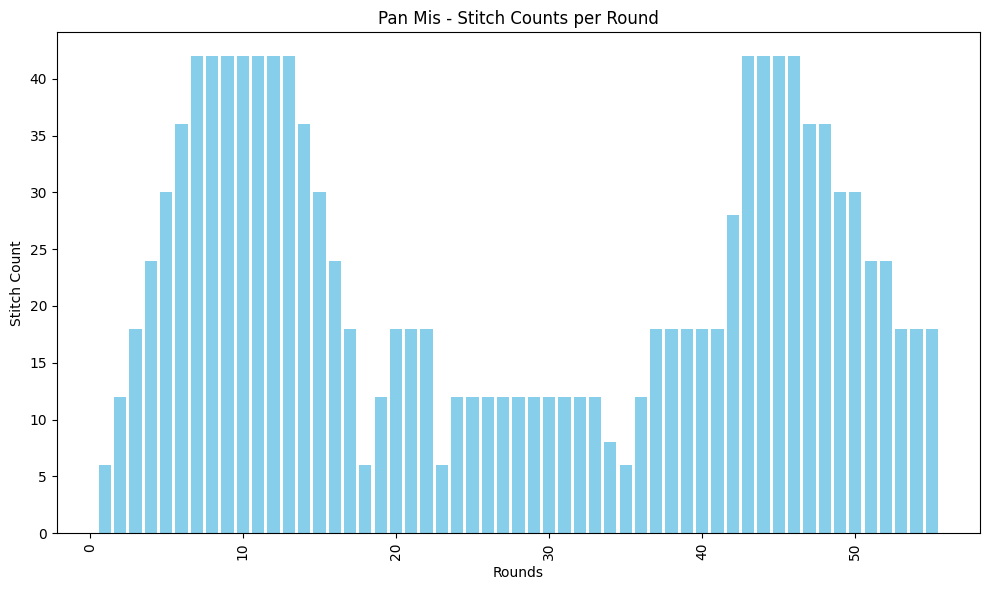

In [654]:
plt.figure(figsize=(10, 6))
plt.bar(df_panmis['round_continuous'].astype(int), df_panmis['count'], color='skyblue')
plt.xticks(rotation=90)
plt.title("Pan Mis - Stitch Counts per Round")
plt.xlabel("Rounds")
plt.ylabel("Stitch Count")
plt.tight_layout()
plt.show()

# bee

In [39]:
import re

# Input sample text
sample_text = """
r1: 6 in mr [6]
r2: inc*6 [12]
r3: (1sc, inc)*6 [18]
r4: (2sc, inc)*6 [24]
r5: (3sc, inc)*6 [30]
r6: (4 sc, inc)*6 [36]
r7: (5sc, inc)*6 [42]
r8: (6sc, inc)*6 [48]
r9-11: sc in each [48]
r12-14: sc in each [48]
r15-16: sc in each [48]
r17-19: sc in each [48]
r20-22: sc in each [48]
r23: (6sc, dec)*6 [42]
r24: (5sc, dec)*6 [36]
r25: (4sc, dec)*6 [30]
r26: (3sc, dec)*6 [24]
r27: (2sc, dec)*6 [18]
r28: (1sc, dec)*6 [12]
r29: dec*6 [6]
"""


result = bee_process_crochet_instructions(sample_text)


In [612]:
df_bee = pd.DataFrame(result)

# Ensure `round` is numeric and continuous, and fill missing `count` with NaN
df_bee['round'] = pd.to_numeric(df_bee['round'], errors='coerce')
df_bee['round_continuous'] = pd.to_numeric(df_bee['round_continuous'], errors='coerce')
df_bee['count'] = pd.to_numeric(df_bee['count'], errors='coerce')

# Sort data by round and remove duplicates (keeping the first occurrence)
df_bee = df_bee.sort_values('round_continuous')

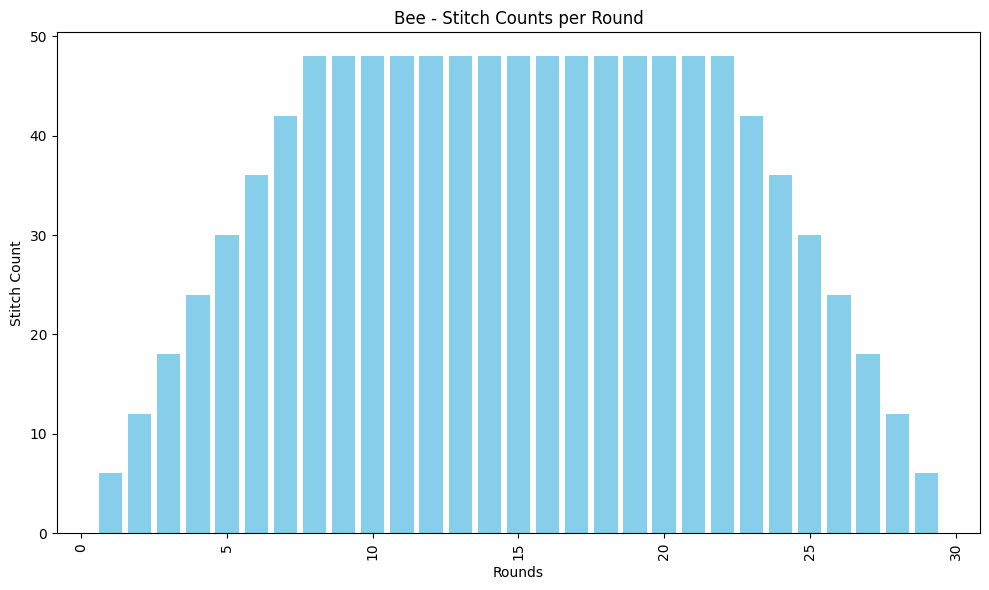

In [613]:
plt.figure(figsize=(10, 6))
plt.bar(df_bee['round_continuous'].astype(int), df_bee['count'], color='skyblue')
plt.xticks(rotation=90)
plt.title("Bee - Stitch Counts per Round")
plt.xlabel("Rounds")
plt.ylabel("Stitch Count")
plt.tight_layout()
plt.show()

6 in mr
inc*6
(1sc, inc)*6
(2sc, inc)*6
(3sc, inc)*6
(4 sc, inc)*6
(5sc, inc)*6
(6sc, inc)*6
sc in each
sc in each
sc in each
sc in each
sc in each
sc in each
sc in each
sc in each
sc in each
sc in each
sc in each
sc in each
sc in each
sc in each
(6sc, dec)*6
(5sc, dec)*6
(4sc, dec)*6
(3sc, dec)*6
(2sc, dec)*6
(1sc, dec)*6
dec*6


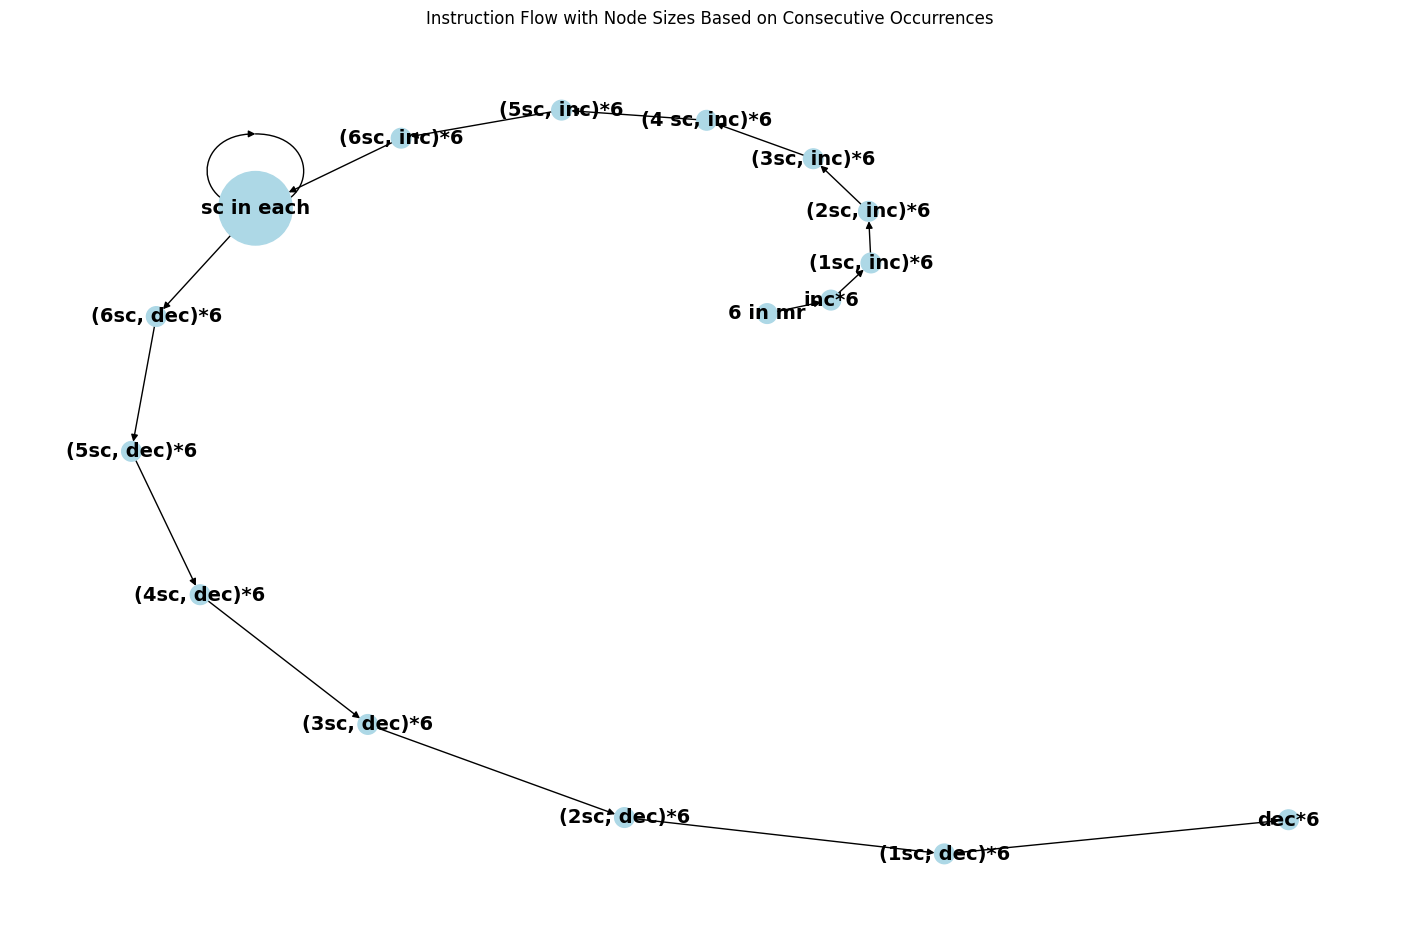

In [627]:
# Count consecutive occurrences of instructions
node_sizes = {}
previous_instruction = None
streak = 1

for entry in result:
    instruction = entry['instructions']
    print(instruction)
    if instruction == previous_instruction:
        streak += 1
    else:
        streak = 1
    node_sizes[instruction] = max(node_sizes.get(instruction, 0), streak)
    previous_instruction = instruction
# print(node_sizes)
# # Create the graph
G = nx.DiGraph()
for i in range(len(result) - 1):
    G.add_edge(result[i]['instructions'], result[i + 1]['instructions'])

# print(G.nodes())
# # Map node sizes based on consecutive occurrences
sizes = [node_sizes[node] * 200 for node in G.nodes()]

# Plot the graph
plt.figure(figsize=(14, 9), facecolor='none')
pos = nx.spiral_layout(G)
nx.draw(
    G,
    pos,
    with_labels=True,
    node_color='lightblue',
    node_size=sizes,
    font_size=14,
    font_weight='bold'
)
plt.title('Instruction Flow with Node Sizes Based on Consecutive Occurrences', )
plt.show()

## comparison

In [223]:
df_jamnik = pd.DataFrame(parsed_rounds)

# Ensure `round` is numeric and continuous, and fill missing `count` with NaN
df_jamnik['round'] = pd.to_numeric(df_jamnik['round_continuous'], errors='coerce')
df_jamnik['count'] = pd.to_numeric(df_jamnik['count'], errors='coerce')

# Sort data by round and remove duplicates (keeping the first occurrence)
df_jamnik = df_jamnik.sort_values('round').drop_duplicates(subset='round')

In [231]:
df_rabbit = pd.DataFrame(structured_data)

# Ensure `round` is numeric and continuous, and fill missing `count` with NaN
df_rabbit['round'] = pd.to_numeric(df_rabbit['round_continuous'], errors='coerce')
df_rabbit['count'] = pd.to_numeric(df_rabbit['count'], errors='coerce')

# Sort data by round and remove duplicates (keeping the first occurrence)
df_rabbit = df_rabbit.sort_values('round').drop_duplicates(subset='round')

In [239]:
df_kroliczek = pd.DataFrame(structured_output)

# Ensure `round` is numeric and continuous, and fill missing `count` with NaN
df_kroliczek['round'] = pd.to_numeric(df_kroliczek['round_continuous'], errors='coerce')
df_kroliczek['count'] = pd.to_numeric(df_kroliczek['count'], errors='coerce')

# Sort data by round and remove duplicates (keeping the first occurrence)
df_kroliczek = df_kroliczek.sort_values('round').drop_duplicates(subset='round')

In [240]:
df_fox = pd.DataFrame(output)

# Ensure `round` is numeric and continuous, and fill missing `count` with NaN
df_fox['round'] = pd.to_numeric(df_fox['round_continuous'], errors='coerce')
df_fox['count'] = pd.to_numeric(df_fox['count'], errors='coerce')

# Sort data by round and remove duplicates (keeping the first occurrence)
df_fox = df_fox.sort_values('round').drop_duplicates(subset='round')

In [398]:
df_fox

,round,round_continuous,instructions,count
0,1,1,6 sc in a mr,6.0
1,2,2,6 inc,12.0
2,3,3,"(3sc, inc)3",15.0
3,4,4,15 sc,15.0
4,5,5,15 sc,15.0
...,...,...,...,...
56,62,62,12 sc,12.0
57,63,63,12 sc,12.0
58,64,64,12 sc,12.0
59,65,65,"(sc, dec)4",8.0


In [248]:
df_reindeer = pd.DataFrame(parsed_result)

# Ensure `round` is numeric and continuous, and fill missing `count` with NaN
df_reindeer['round'] = pd.to_numeric(df_reindeer['round_continuous'], errors='coerce')
df_reindeer['count'] = pd.to_numeric(df_reindeer['count'], errors='coerce')

# Sort data by round and remove duplicates (keeping the first occurrence)
df_reindeer = df_reindeer.sort_values('round').drop_duplicates(subset='round')

In [269]:
df_duck = pd.DataFrame(results)

# Ensure `round` is numeric and continuous, and fill missing `count` with NaN
df_duck['round'] = pd.to_numeric(df_duck['round_continuous'], errors='coerce')
df_duck['count'] = pd.to_numeric(df_duck['count'], errors='coerce')

# Sort data by round and remove duplicates (keeping the first occurrence)
df_duck = df_duck.sort_values('round').drop_duplicates(subset='round')

In [328]:
df_penguin = pd.DataFrame(results)

# Ensure `round` is numeric and continuous, and fill missing `count` with NaN
df_penguin['round'] = pd.to_numeric(df_penguin['round_continuous'], errors='coerce')
df_penguin['count'] = pd.to_numeric(df_penguin['count'], errors='coerce')

# Sort data by round and remove duplicates (keeping the first occurrence)
df_penguin = df_penguin.sort_values('round').drop_duplicates(subset='round')

In [376]:
df_panda = pd.DataFrame(results)

# Ensure `round` is numeric and continuous, and fill missing `count` with NaN
df_panda['round'] = pd.to_numeric(df_panda['round_continuous'], errors='coerce')
df_panda['count'] = pd.to_numeric(df_panda['count'], errors='coerce')

# Sort data by round and remove duplicates (keeping the first occurrence)
df_panda = df_panda.sort_values('round').drop_duplicates(subset='round')

In [394]:
df_panmis = pd.DataFrame(structured_output)

# Ensure `round` is numeric and continuous, and fill missing `count` with NaN
df_panmis['round'] = pd.to_numeric(df_panmis['round_continuous'], errors='coerce')
df_panmis['count'] = pd.to_numeric(df_panmis['count'], errors='coerce')

# Sort data by round and remove duplicates (keeping the first occurrence)
df_panmis = df_panmis.sort_values('round').drop_duplicates(subset='round')

In [655]:
df_bee

,round,round_continuous,instructions,count
0,1,1,6 in mr,6
1,2,2,inc*6,12
2,3,3,"(1sc, inc)*6",18
3,4,4,"(2sc, inc)*6",24
4,5,5,"(3sc, inc)*6",30
5,6,6,"(4 sc, inc)*6",36
6,7,7,"(5sc, inc)*6",42
7,8,8,"(6sc, inc)*6",48
8,9,9,sc in each,48
9,10,10,sc in each,48


In [656]:
df_duck

,round,round_continuous,instructions,count
0,1,1,ch 2 and insert 8 sc in the 2nd ch from hook,8
1,2,2,inc around,16
2,3,3,(sc; inc)*8,24
3,4,4,sc around,24
4,5,5,sc around,24
5,6,6,sc around,24
6,7,7,sc around,24
7,8,8,dec around,12
8,9,9,inc around,24
9,10,10,"sc 22, inc 2",26


In [659]:
df_kroliczek

,round,round_continuous,instructions,count
0,1,1,6 in mr,6
1,2,2,inc*6,12
2,3,3,"(1sc, inc)*6",18
3,4,4,"(2sc, inc)*6",24
4,5,5,"(3sc, inc)*6",30
...,...,...,...,...
77,19,78,"(dec, 5sc)*2",12
78,19,79,"(dec, 5sc)*2",12
79,20,80,sc in each,12
80,21,81,"(dec, 4sc)*2",10


In [661]:
df_panda

,round,round_continuous,instructions,count
0,1,1,6 in mr [6],6
1,2,2,inc*6 [12],12
2,3,3,"(1sc, inc)*6 [18]",18
3,4,4,"(2sc, inc)*6 [24]",24
4,5,5,"(3sc, inc)*6 [30]",30
5,6,6,"(4 sc, inc) *6 [36]",36
6,7,7,"(5sc, inc)*6 [42]",42
7,8,8,-r13: sc in each [42],42
8,14,9,"(5sc, dec)*6 [36]",36
9,15,10,"(4sc, dec)*6 [30]",30


## first comparison

In [676]:
dataset_names = ["Penguin", "Duck", "Bee", "Fox", "Dachshund", "Rabbit (PL)", "Bear", "Panda", "Mr. Bear", "Rabbit", "Reindeer"] 

In [677]:
# Load and combine data
dataframes = [df_penguin, df_duck, df_bee, df_fox, df_jamnik, df_kroliczek, df_misio, df_panda, df_panmis, df_rabbit, df_reindeer]  
len(dataframes)

11

In [678]:
for i, df in enumerate(dataframes):
    df['dataset'] = dataset_names[i]
combined_df = pd.concat(dataframes, ignore_index=True)

In [683]:
# Extract round 1 instructions
round_1_df = combined_df[combined_df['round'] == 1][['dataset', 'instructions']]

# Clean and preprocess the instructions
round_1_df['instructions'] = round_1_df['instructions'].str.lower().str.replace(r'[^a-z0-9\s\(\),]', '', regex=True)

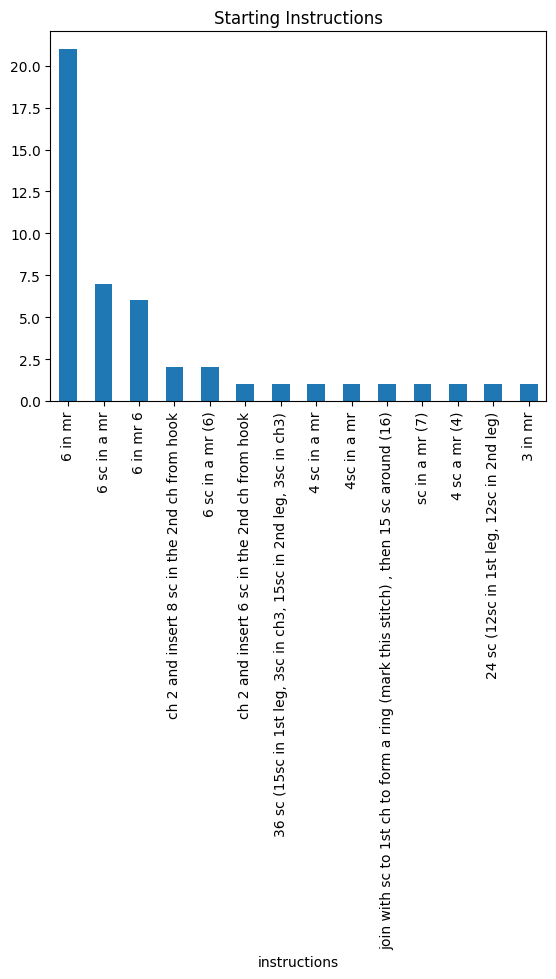

In [684]:
# Idea 1: Compare Starting Instructions
# round1_df = combined_df[combined_df['round'] == 1]
start_instructions = round_1_df['instructions'].value_counts()
start_instructions.plot(kind='bar', title='Starting Instructions')
plt.show()

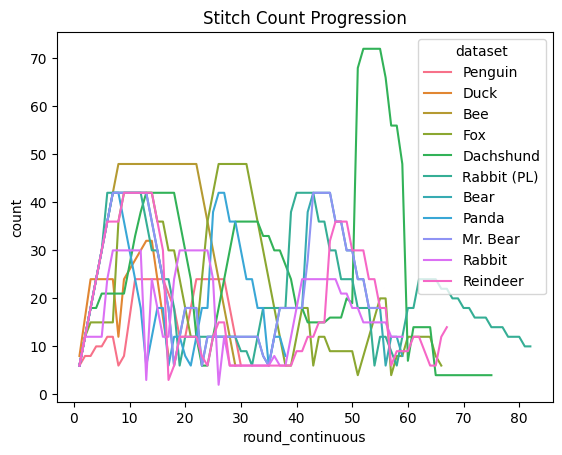

In [691]:
# Idea 3: Stitch Count Progression
sns.lineplot(data=combined_df, x='round_continuous', y='count', hue='dataset')
plt.title('Stitch Count Progression')
plt.show()


In [741]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#4D2B4D', '#CB97CB', '#e7d6e7', '#CCBCAE','#C7E7F4', '#94C8DD', '#386475']
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)  # Create custom colormap

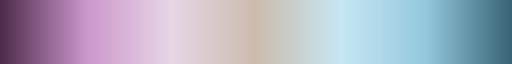

In [742]:
custom_cmap

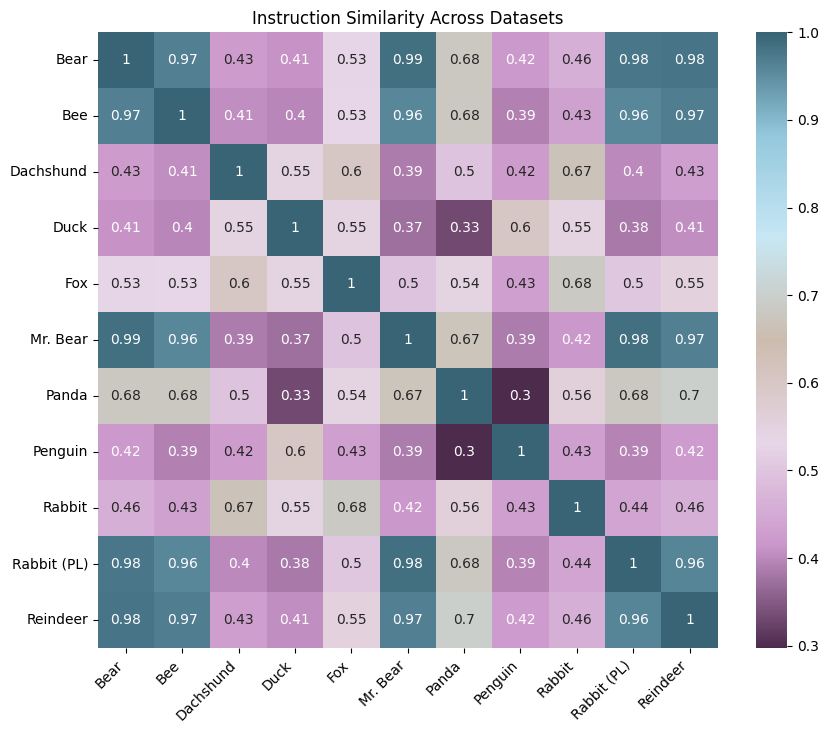

In [743]:
combined_df['instructions'] = combined_df['instructions'].str.lower().str.replace(r'[^a-z0-9\s\(\),]', '', regex=True)

# Pivot the data to create a similarity matrix
pivot_df = combined_df.pivot(index='dataset', columns='round_continuous', values='instructions').fillna('')

# Use TF-IDF Vectorizer to represent instructions
tfidf_vectorizer = TfidfVectorizer()
instruction_matrix = tfidf_vectorizer.fit_transform(pivot_df.apply(lambda row: ' '.join(row), axis=1))

# Compute cosine similarity
similarity_matrix = cosine_similarity(instruction_matrix)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, xticklabels=pivot_df.index, yticklabels=pivot_df.index, cmap=custom_cmap, annot=True)
plt.title('Instruction Similarity Across Datasets')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

## data standarization

In [783]:
import re

def standardize_instruction(instruction):
    instruction = instruction.lower().strip()  # Convert to lowercase, remove extra spaces
    # Standardize magic ring instructions (handles 4 in mr, 4 sc a mr, etc.)
    instruction = re.sub(r'(\d+)\s*(sc)?\s*(a|in|into|to)?\s*(a\s*)?mr', r'\1 in mr', instruction)
    # Standardize chain instructions
    instruction = re.sub(r'ch\s*(\d+),?\s*(then\s*)?(insert|make|do|work)?', r'ch \1', instruction)
    # Remove numbers in parentheses and trailing numbers
    instruction = re.sub(r'\s*\(\d+\)|\s*\d+$', '', instruction)
    # Remove variations in phrasing or extra info
    instruction = re.sub(r'(mark\s*this\s*stitch|join\s*with\s*st\s*to\s*.*|to\s*form\s*a\s*ring).*', '', instruction)
    instruction = re.sub(r'\s+', ' ', instruction).strip()  # Remove extra spaces
    return instruction


In [794]:
combined_df['standard_instructions'] = combined_df['instructions'].apply(standardize_instruction)

# Extract and count Round 1 instructions
round_1_instructions = combined_df[combined_df['round'] == 1]['standard_instructions'].value_counts()
round_1_instructions.columns = ['Instruction', 'Frequency']
round_1_instructions

round_1_instructions = combined_df[combined_df['round'] == 1]['standard_instructions'].value_counts().reset_index()
round_1_instructions.columns = ['Instruction', 'Frequency']
round_1_instructions

,Instruction,Frequency
0,6 in mr,36
1,4 in mr,3
2,ch 2and insert 8 sc in the 2nd ch from hook,2
3,ch 2and insert 6 sc in the 2nd ch from hook,1
4,"36 sc (15sc in 1st leg, 3sc in ch 315sc in 2nd...",1
5,join with sc to 1st ch,1
6,sc in a mr,1
7,"24 sc (12sc in 1st leg, 12sc in 2nd leg)",1
8,3 in mr,1


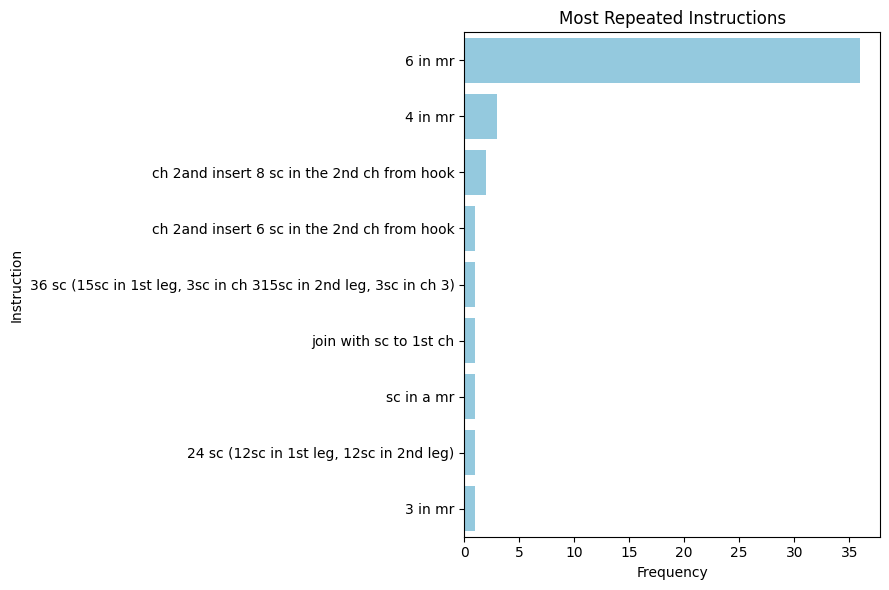

In [796]:
plt.figure(figsize=(9, 6))
sns.barplot(data=round_1_instructions.head(10), x="Frequency", y="Instruction", color='skyblue')
plt.title("Most Repeated Instructions")
plt.xlabel("Frequency")
plt.ylabel("Instruction")
plt.tight_layout()
plt.show()

/var/folders/4v/rn4fv5dd2wz59bdn6tk48q0w0000gn/T/ipykernel_14126/1924739193.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels)


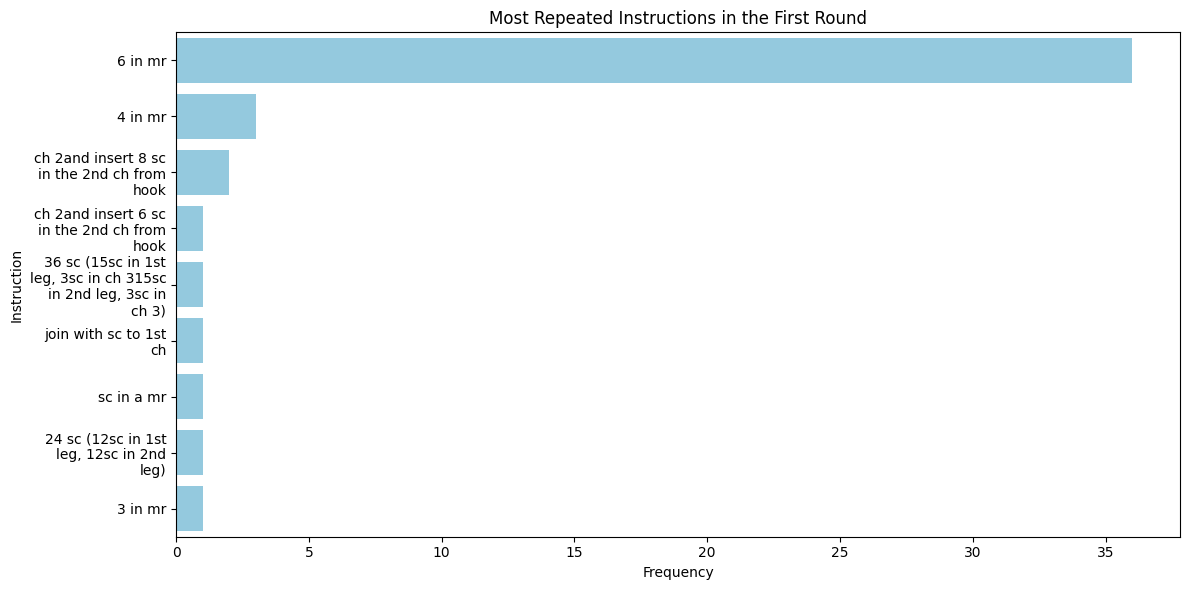

In [839]:
import textwrap

def wrap_labels(ax, width):
    labels = [textwrap.fill(label.get_text(), width) for label in ax.get_yticklabels()]
    ax.set_yticklabels(labels)

# Plotting
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=round_1_instructions.head(10), x="Frequency", y="Instruction", color='skyblue')
wrap_labels(ax, 20)  # Wrap labels to a width of 30 characters
plt.title("Most Repeated Instructions in the First Round")
plt.xlabel("Frequency")
plt.ylabel("Instruction")
plt.tight_layout()
plt.show()

In [702]:
grouped_by_count = combined_df.groupby('count')
for count, group in grouped_by_count:
    print(f"Stitch Count: {count}")
    print(group[['dataset', 'round_continuous', 'instructions']])

Stitch Count: 2
    dataset  round_continuous        instructions
476  Rabbit                26  (2 sc, dec) 6 6 81
Stitch Count: 3
      dataset  round_continuous     instructions
463    Rabbit                13  (3sc, dec)6 (24
526  Reindeer                17          3 in mr
Stitch Count: 4
       dataset  round_continuous   instructions
126        Fox                51   4 sc in a mr
132        Fox                57    4sc in a mr
206  Dachshund                65  4 sc a mr (4)
207  Dachshund                66       4 sc (4)
208  Dachshund                67       4 sc (4)
209  Dachshund                68       4 sc (4)
210  Dachshund                69       4 sc (4)
211  Dachshund                70       4 sc (4)
212  Dachshund                71       4 sc (4)
213  Dachshund                72       4 sc (4)
214  Dachshund                73       4 sc (4)
215  Dachshund                74       4 sc (4)
216  Dachshund                75       4 sc (4)
Stitch Count: 6
      dataset  ro

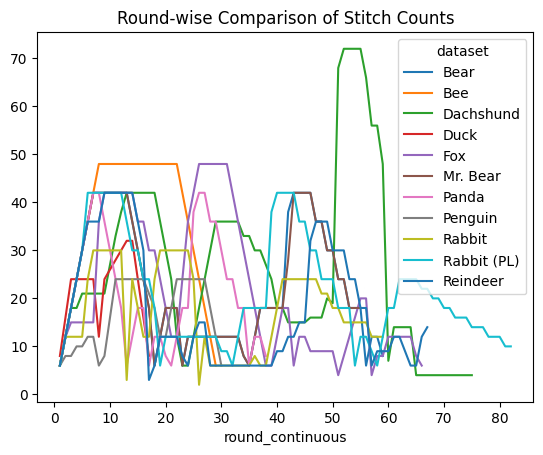

In [701]:
# Align and visualize round-wise comparisons
aligned_data = combined_df.pivot_table(index='round_continuous', columns='dataset', values='count', aggfunc='mean')
aligned_data.plot(title='Round-wise Comparison of Stitch Counts')
plt.show()


In [704]:
from scipy.stats import zscore
combined_df['z_score'] = zscore(combined_df['count'])
anomalies = combined_df[combined_df['z_score'].abs() > 2]
anomalies

,round,round_continuous,instructions,count,dataset,standard_instructions,growth_rate,z_score
192,6,51,"hdc inc, hdc, hdcinc, 18 hdc, 22 sc, 18 hdc, h...",68,Dachshund,"hdc inc, hdc, hdcinc, 18 hdc, 22 sc, 18 hdc, h...",2.578947,3.391291
193,7,52,"hdc inc, 2 hdc, hdc inc, 19 hdc, 22 sc, 19 hdc...",72,Dachshund,"hdc inc, 2 hdc, hdc inc, 19 hdc, 22 sc, 19 hdc...",0.058824,3.685620
194,8,53,72 sc (3 rounds of 72),72,Dachshund,72 sc (3 rounds of 72),0.000000,3.685620
195,9,54,72 sc (3 rounds of 72),72,Dachshund,72 sc (3 rounds of 72),0.000000,3.685620
196,10,55,72 sc (3 rounds of 72),72,Dachshund,72 sc (3 rounds of 72),0.000000,3.685620
197,11,56,"4 sc, dec, 20 sc, dec, (4 sc, dec)3, 20 sc, de...",66,Dachshund,"4 sc, dec, 20 sc, dec, (4 sc, dec)3, 20 sc, de...",-0.083333,3.244126
198,12,57,56sc (56),56,Dachshund,56sc (56),-0.151515,2.508303
199,13,58,"(sc, dec)2, 19sc, dec, (sc, dec)4, 19 sc, dec,...",56,Dachshund,"(sc, dec)2, 19sc, dec, (sc, dec)4, 19 sc, dec,...",0.000000,2.508303


In [705]:
unique_instructions = combined_df['instructions'].unique()
standardized_dict = {instr: standardize_instruction(instr) for instr in unique_instructions}

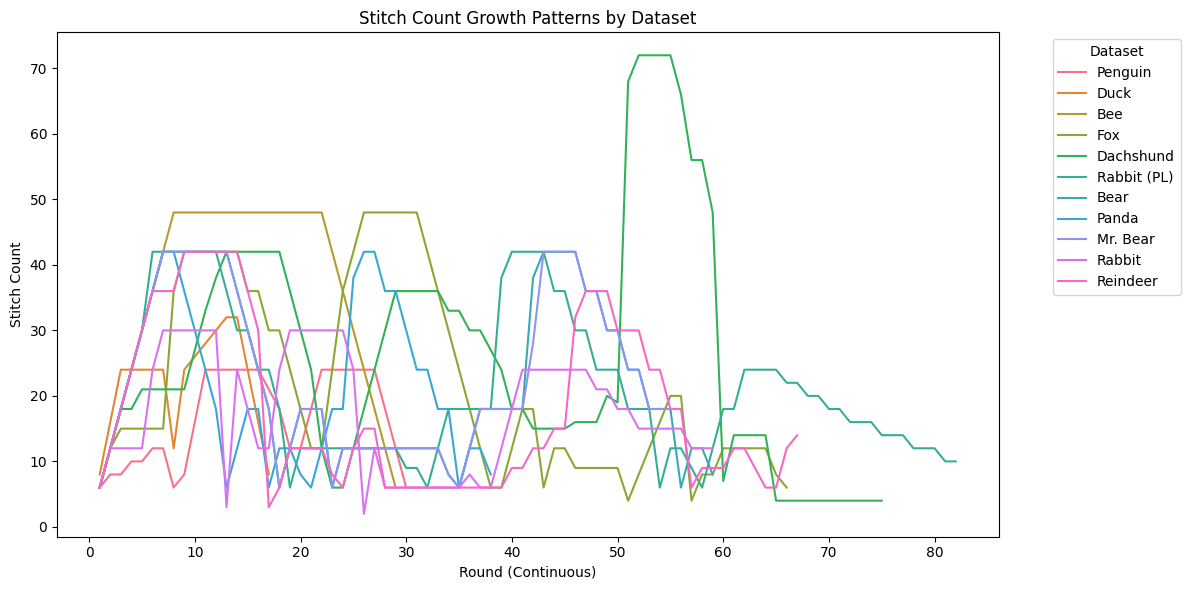

In [745]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot stitch count trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=combined_df, x="round_continuous", y="count", hue="dataset")
plt.title("Stitch Count Growth Patterns by Dataset")
plt.xlabel("Round (Continuous)")
plt.ylabel("Stitch Count")
plt.legend(title="Dataset", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

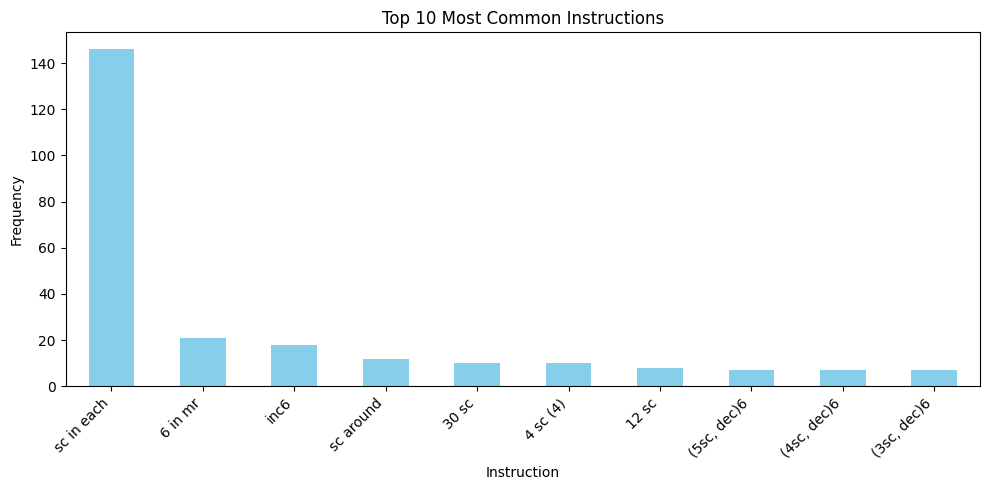

In [717]:
from collections import Counter

# Calculate instruction frequency
instruction_counts = combined_df['instructions'].value_counts().head(10)

# Plot most common instructions
plt.figure(figsize=(10, 5))
instruction_counts.plot(kind="bar", color="skyblue")
plt.title("Top 10 Most Common Instructions")
plt.xlabel("Instruction")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


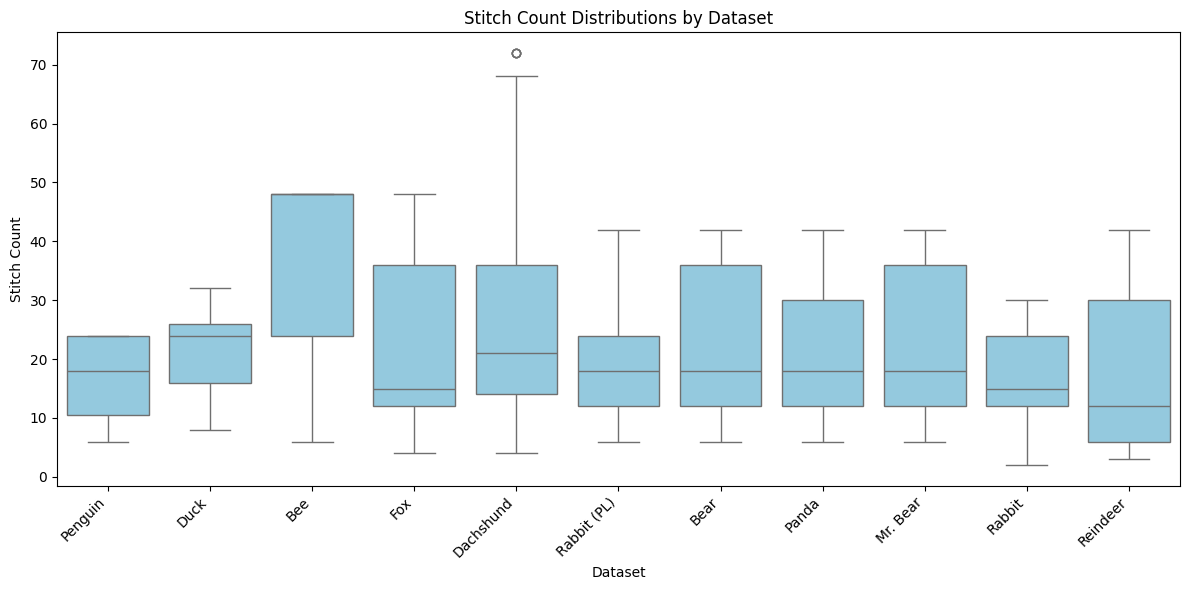

In [720]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=combined_df, x="dataset", y="count", color='skyblue')
plt.title("Stitch Count Distributions by Dataset")
plt.xlabel("Dataset")
plt.ylabel("Stitch Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [726]:
# Check for symmetry in counts
combined_df['is_symmetric'] = combined_df['count'] == combined_df['count'].iloc[::-1].reset_index(drop=True)
symmetric_datasets = combined_df[combined_df['is_symmetric']]['dataset'].unique()

print(f"Symmetric Datasets: {symmetric_datasets}")

Symmetric Datasets: ['Penguin' 'Bee' 'Fox' 'Dachshund' 'Rabbit (PL)' 'Bear' 'Mr. Bear'
 'Rabbit' 'Reindeer']


In [ ]:
combined_df['standard_instructions'] = combined_df['instructions'].apply(standardize_instruction)

# Extract and count Round 1 instructions
round_1_instructions = combined_df[combined_df['round'] == 1]['standard_instructions'].value_counts()
round_1_instructions.columns = ['Instruction', 'Frequency']
round_1_instructions

round_1_instructions = combined_df[combined_df['round'] == 1]['standard_instructions'].value_counts().reset_index()
round_1_instructions.columns = ['Instruction', 'Frequency']
round_1_instructions

In [840]:
repeated_instructions = combined_df['standard_instructions'].value_counts().reset_index()

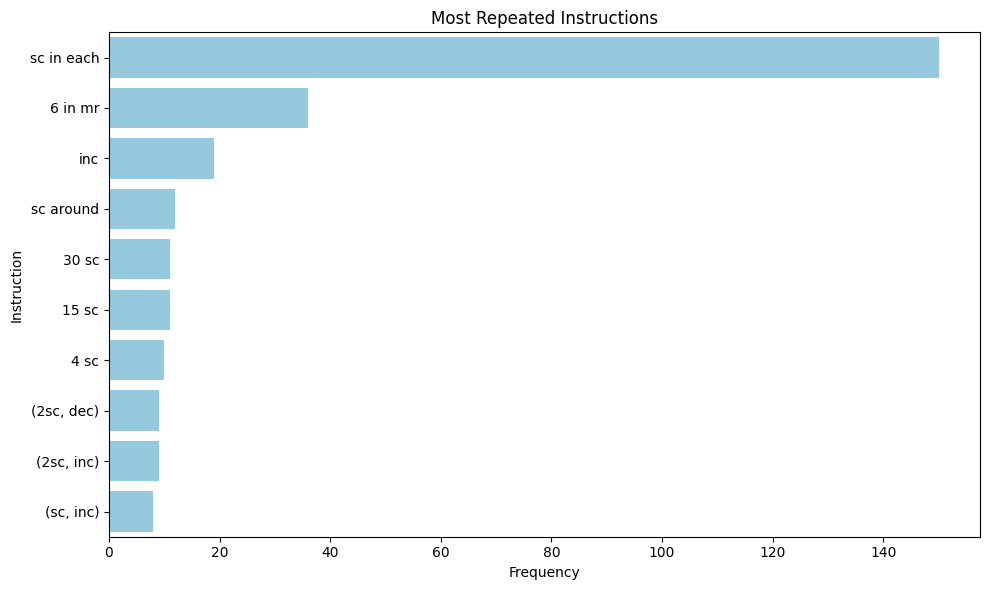

In [841]:
# Visualize repetitions
repeated_instructions = combined_df['standard_instructions'].value_counts().reset_index()
repeated_instructions.columns = ['Instruction', 'Frequency']

plt.figure(figsize=(10, 6))
sns.barplot(data=repeated_instructions.head(10), x="Frequency", y="Instruction", color='skyblue')
plt.title("Most Repeated Instructions")
plt.xlabel("Frequency")
plt.ylabel("Instruction")
plt.tight_layout()
plt.show()

Word cloud

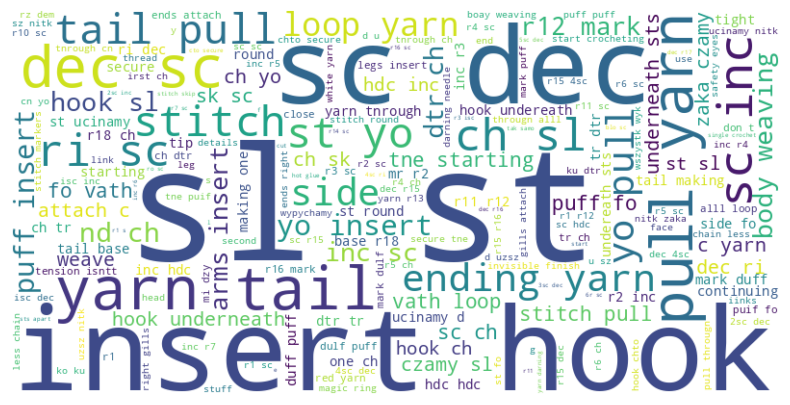

In [749]:
import os
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from charset_normalizer import detect

# Directory containing the .txt files
path_to_txt = os.path.join('data', 'Jula')

# Get a list of all .txt files in the directory
txt_files = [os.path.join(path_to_txt, file) for file in os.listdir(path_to_txt) if file.endswith('.txt')]

# Combine all text from the .txt files
all_text = ""
for txt_file in txt_files:
    with open(txt_file, 'rb') as file:  # Open in binary mode
        raw_data = file.read()
        detected_encoding = detect(raw_data)['encoding']  # Detect encoding
        try:
            all_text += raw_data.decode(detected_encoding) + " "  # Decode using the detected encoding
        except Exception as e:
            print(f"Error decoding {txt_file} with encoding {detected_encoding}: {e}")

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(all_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes
plt.show()


In [828]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#4D2B4D', '#CB97CB', '#A28F7F', '#94C8DD', '#386475']
custom_cmap_2 = LinearSegmentedColormap.from_list("custom_cmap", colors)  # Create custom colormap

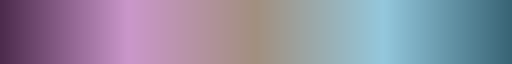

In [829]:
custom_cmap_2

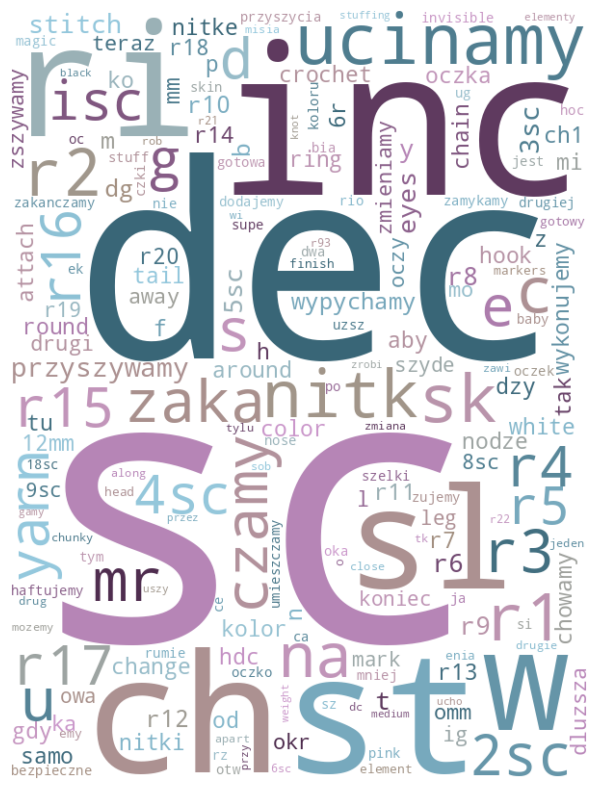

In [836]:
import os
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from charset_normalizer import detect

# Directory containing the .txt files
path_to_txt = os.path.join('data', 'Jula')

# Get a list of all .txt files in the directory
txt_files = [os.path.join(path_to_txt, file) for file in os.listdir(path_to_txt) if file.endswith('.txt')]

# Combine all text from the .txt files
all_text = ""
for txt_file in txt_files:
    with open(txt_file, 'rb') as file:  # Open in binary mode
        raw_data = file.read()
        detected_encoding = detect(raw_data)['encoding']  # Detect encoding
        all_text += raw_data.decode(detected_encoding) + " "


# Generate the word cloud
wordcloud = WordCloud(
    width=600,
    height=800,
    background_color='white',
    colormap=custom_cmap_2,
    contour_width=1, 
    collocations=False
).generate(all_text)

# Display the word cloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes
plt.show()